In [2]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from sklearn.preprocessing import StandardScaler

In [4]:
random_seed = 2022
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

In [5]:
data_dir = '/USER/data002'

In [272]:
df = pd.read_csv(os.path.join(data_dir,'train.csv'))

In [7]:
df.head()

날짜  시간     10    100   101   120   121   140    150   160  ...  1020  \
0  20200101   0  83247  19128  2611  5161  1588   892  32263  1636  ...  1311   
1  20200101   1  89309  19027  3337  5502  1650  1043  35609  1644  ...  1162   
2  20200101   2  66611  14710  2970  4631  1044   921  26821  1104  ...   768   
3  20200101   3  53290  13753  2270  4242  1021   790  21322   909  ...   632   
4  20200101   4  52095  17615  2406  3689  1840   922  22711  1354  ...   875   

   1040   1100  1200  1510  2510  3000  4510  5510  6000  
0  3482  11299  7072  1176  3810   748  3920  2133  3799  
1  3849  13180  8771  1283  3763   782  3483  2057  4010  
2  2299   7986  5426  1536  3229   491  2634  1526  3388  
3  1716   5703  3156  1104  2882   431  2488  1268  3686  
4  2421   5816  2933  1206  2433   499  2952  1927  5608  

[5 rows x 37 columns]

In [243]:
df_col = df.columns.values

In [274]:
df[df_col[2:]] += 1

In [245]:
scaler = StandardScaler()
scaler.fit(df[df.columns.values[2:]])

StandardScaler()

In [141]:
len(df[df['날짜']!=20200229][df['날짜']!=20200330])/24

## Data Preprocessing
##### 20200229 & 20200330 제거 후 작업

In [305]:
class CustomDataset(Dataset) :
    def __init__(self, data_dir, mode, seq_len, scaler) :
        self.data_dir = data_dir
        self.mode = mode
        self.seq_len = seq_len*24
        
        df_path = os.path.join(self.data_dir, mode+'.csv')
        df = pd.read_csv(df_path)
        df_col = df.columns.values
        df_scale = scaler.transform(df[df_col[2:]])
        df[df_col[2:]] = df_scale
        
        if mode == 'train' :
            df_train = df[df['날짜']!=20200229][df['날짜']!=20200330]

            self.input_data = []
            self.output_data = []

            for t in range(0,len(df_train)-2*self.seq_len,24) :
                temp_input_data = []
                temp_output_data = []
                for col in df_col[2:] :
                    road = df_train[col].tolist()
                    temp_input = [float(i) for i in road[t: t+self.seq_len]]
                    temp_output = [float(j) for j in road[t+self.seq_len:t+2*self.seq_len]]
                    temp_input_data.append(temp_input)
                    temp_output_data.append(temp_output)
                self.input_data.append(temp_input_data)
                self.output_data.append(temp_output_data)
                
        elif mode == 'valid' :

            self.input_data = []
            self.output_data = []

            temp_input_data = []
            temp_output_data = []
            for col in df_col[2:] :
                road = df[col].tolist()
                temp_input = [float(i) for i in road[:self.seq_len]]
                temp_output = road[self.seq_len:self.seq_len*2]
                temp_input_data.append(temp_input)
                temp_output_data.append(temp_output)
            self.input_data.append(temp_input_data)
            self.output_data.append(temp_output_data)
            
        elif mode == 'test' :
            
            self.input_data = []

            
            temp_input_data = []
            for col in df_col[2:] :
                road = df[col].tolist()
                temp_input = [float(i) for i in road[:self.seq_len]]
                temp_input_data.append(temp_input)
            self.input_data.append(temp_input_data)
            
    def __getitem__(self, index) :
        day = index // 35
        col = index % 35
        
        if self.mode == 'test' :
            x = torch.tensor(self.input_data[day][col])
            
            return x
        
        x = torch.tensor(self.input_data[day][col])
        label = torch.tensor(self.output_data[day][col])
        # if label.shape[0] != 168:
        #     print('day', 'co', day, col)
        return x, label
    
    def __len__(self) :
        return len(self.input_data)*35

In [11]:
class LSTM(nn.Module) :
    def __init__(self, input_size, hidden_dim, output_size, num_layers=4, batch_size=64, bidirectional=False, dropout=0.3, batch_first=True) :
        super(NBeats, self).__init__()
        self.n_direction = 2 if bidirectional else 1
        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.num_layers = num_layers
        self.batch_first = batch_first

        self.rnn1 = nn.LSTM(input_size = self.input_size,
                            hidden_size = self.hidden_dim,
                            num_layers = self.num_layers,
                            dropout = dropout,
                            bias = True,
                            batch_first = self.batch_first,
                            bidirectional = bidirectional)
        self.rnn2 = nn.LSTM(input_size = self.hidden_dim,
                            hidden_size = self.hidden_dim,
                            num_layers = self.num_layers,
                            dropout = dropout,
                            bias = True,
                            batch_first = self.batch_first,
                            bidirectional = bidirectional)

        self.activation = nn.LeakyReLU(0.2)
            
        self.out = nn.Linear(self.hidden_dim*self.n_direction, self.output_size)
        
        self.h_in = nn.Parameter(torch.zeros(num_layers, 1, hidden_dim, requires_grad=True)).to(device)
        self.c_in = nn.Parameter(torch.zeros(num_layers, 1, hidden_dim, requires_grad=True)).to(device)
        
    def forward(self, x) :
        h_in = self.h_in.expand(self.h_in.shape[0], x.shape[0], self.h_in.shape[2])
        c_in = self.c_in.expand(self.c_in.shape[0], x.shape[0], self.c_in.shape[2])
        
        output, (h1, c1) = self.rnn1(x, (h_in.contiguous(), c_in.contiguous()))
        output = self.activation(output)

        output, (h2, c2) = self.rnn2(output, (h1, c1))
        output = self.activation(output)

        output = self.out(output)

        return output, (h2, c2)

In [12]:
class RNN(nn.Module) :
    def __init__(self, input_size, hidden_dim, output_size, mode='gru', num_layers=4, batch_size=64, bidirectional=False, dropout=0.3, batch_first=True) :
        super(NBeats, self).__init__()
        self.mode = mode
        self.n_direction = 2 if bidirectional else 1
        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        if self.mode == 'gru' :
            self.rnn1 = nn.GRU(input_size = self.input_size,
                               hidden_size = self.hidden_dim,
                               num_layers = self.num_layers,
                               dropout = dropout,
                               bias = True,
                               batch_first = self.batch_first,
                               bidirectional = bidirectional)
            self.rnn2 = nn.GRU(input_size = self.hidden_dim,
                               hidden_size = self.hidden_dim,
                               num_layers = self.num_layers,
                               dropout = dropout,
                               bias = True,
                               batch_first = self.batch_first,
                               bidirectional = bidirectional)
        else :
            self.rnn1 = nn.RNN(input_size = self.input_size,
                               hidden_size = self.hidden_dim,
                               num_layers = self.num_layers,
                               dropout = dropout,
                               bias = True,
                               batch_first = self.batch_first,
                               bidirectional = bidirectional)
            self.rnn2 = nn.RNN(input_size = self.hidden_dim,
                               hidden_size = self.hidden_dim,
                               num_layers = self.num_layers,
                               dropout = dropout,
                               bias = True,
                               batch_first = self.batch_first,
                               bidirectional = bidirectional)
        
        self.activation = nn.LeakyReLU(0.2)
            
        self.out = nn.Linear(self.hidden_dim*self.n_direction, self.output_size)
        
        self.h_in = nn.Parameter(torch.zeros(num_layers, 1, hidden_dim, requires_grad=True)).to(device)
        
    def forward(self, x, h0) :
        h_in = self.h_in.expand(self.h_in.shape[0], x.shape[0], self.h_in.shape[2])
        
        output, h1 = self.rnn1(x, h0)
        output = self.activation(output)

        output, h2 = self.rnn2(output, h1)
        output = self.activation(output)

        output = self.out(output)

        return output, h2

In [331]:
# 결과 파일과 모델 가중치 파일 저장을 위해 log 디렉토리 생성. 중요한 파일이 덮어씌워지지 않도록 주의
os.makedirs('log', exist_ok=True)      # log 폴더 생성, 이미 생성되었을 시 추가로 생성하지 않도록 exist_ok=True


def save_model(model_name, model, optimizer):      # 모델 가중치 파일 저장 함수
    state = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler' : scheduler.state_dict()
    }
    torch.save(state, os.path.join('log', model_name + '.pt'))
    print('model saved\n')


def load_model(model_name, model, optimizer=None):      # 모델 가중치 파일 로드 함수
    state = torch.load(os.path.join('log',model_name))
    model.load_state_dict(state['model'])
    if optimizer is not None:
        optimizer.load_state_dict(state['optimizer'])
    print('model loaded')

In [326]:
dtype = torch.float
num_epochs = 20
learning_rate = 1e-3
seq_len = 7

input_size = 1
hidden_dim = 1024
output_size = 1
batch_size = 64
num_layers = 4

In [306]:
train_dataset = CustomDataset(data_dir=data_dir, mode='train', scaler=scaler, seq_len=seq_len)
valid_dataset = CustomDataset(data_dir=data_dir, mode='valid', scaler=scaler, seq_len=seq_len)

In [307]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [308]:
length = 0
for i, (input_data,output_data) in enumerate(train_dataset) :
    if len(input_data) != 168 or len(output_data) != 168 :
        print(i//35,i%35,len(output_data))

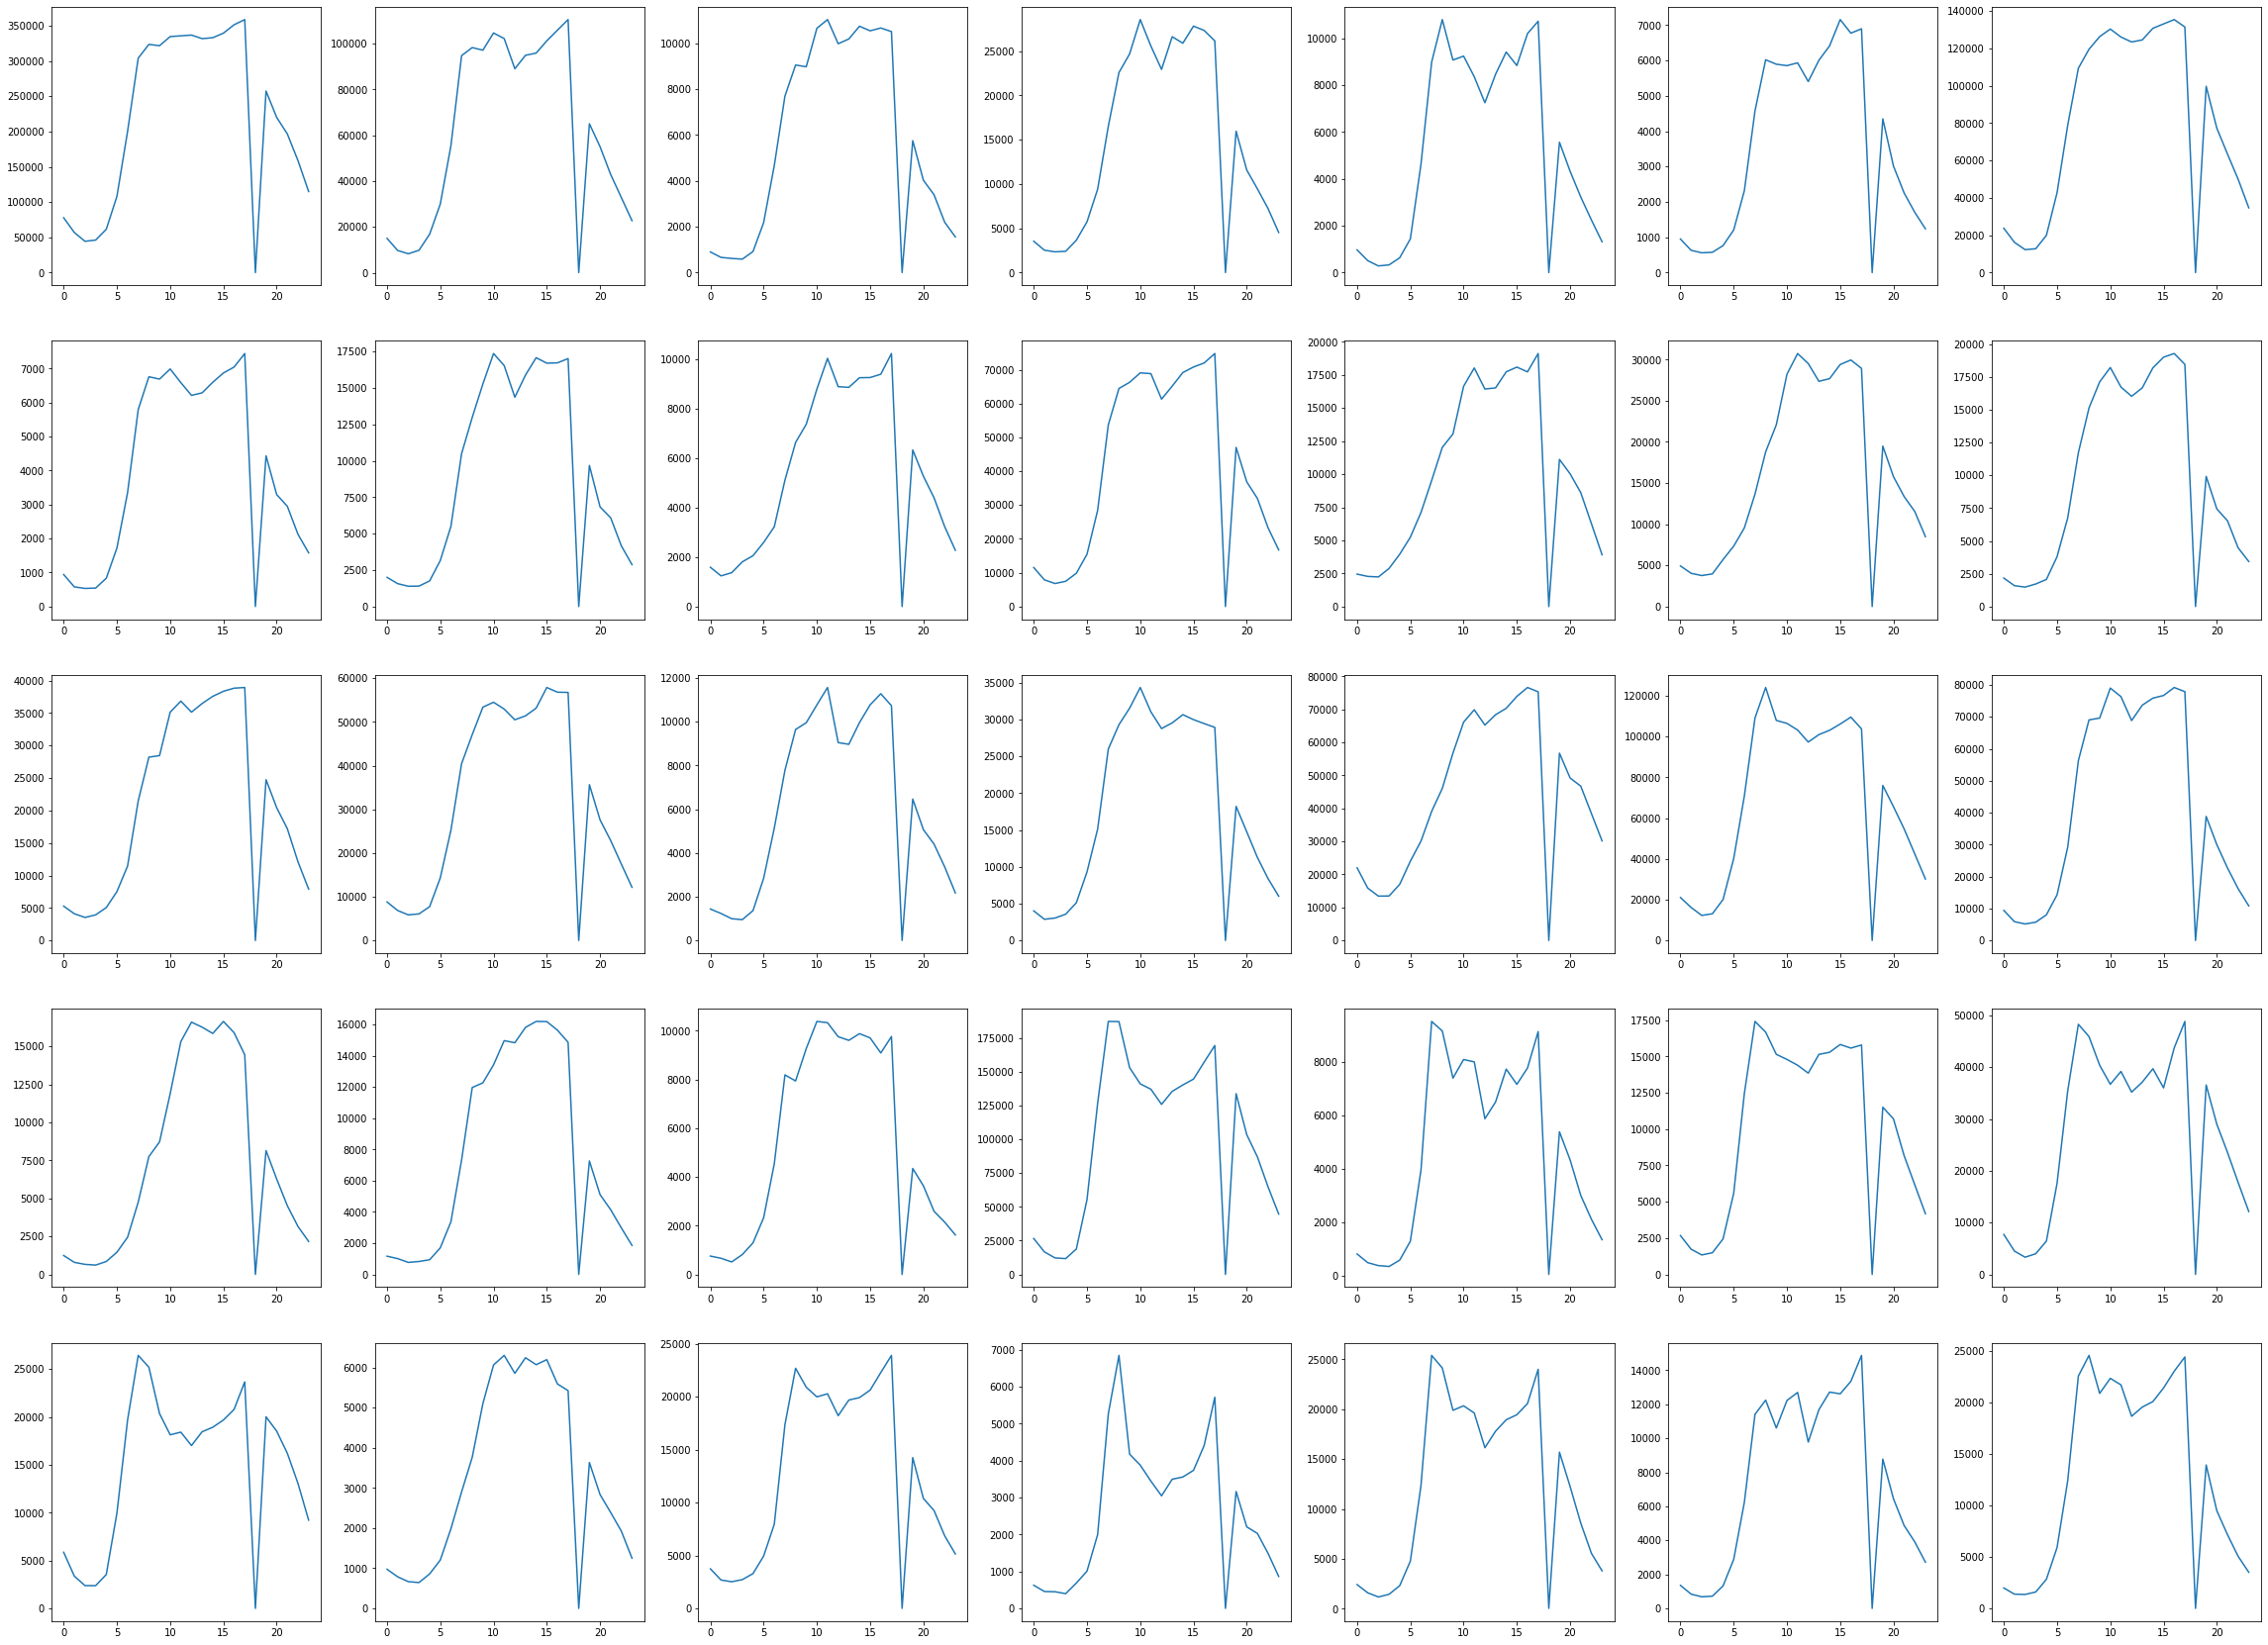

In [219]:
fig, axes = plt.subplots(5,7, figsize=(40,30))
for i in range(len(df_col[2:])) :
    axes[i//7][i%7].plot(df[df_col[1]].iloc[864:888],df[df_col[i+2]].iloc[864:888])
plt.show()

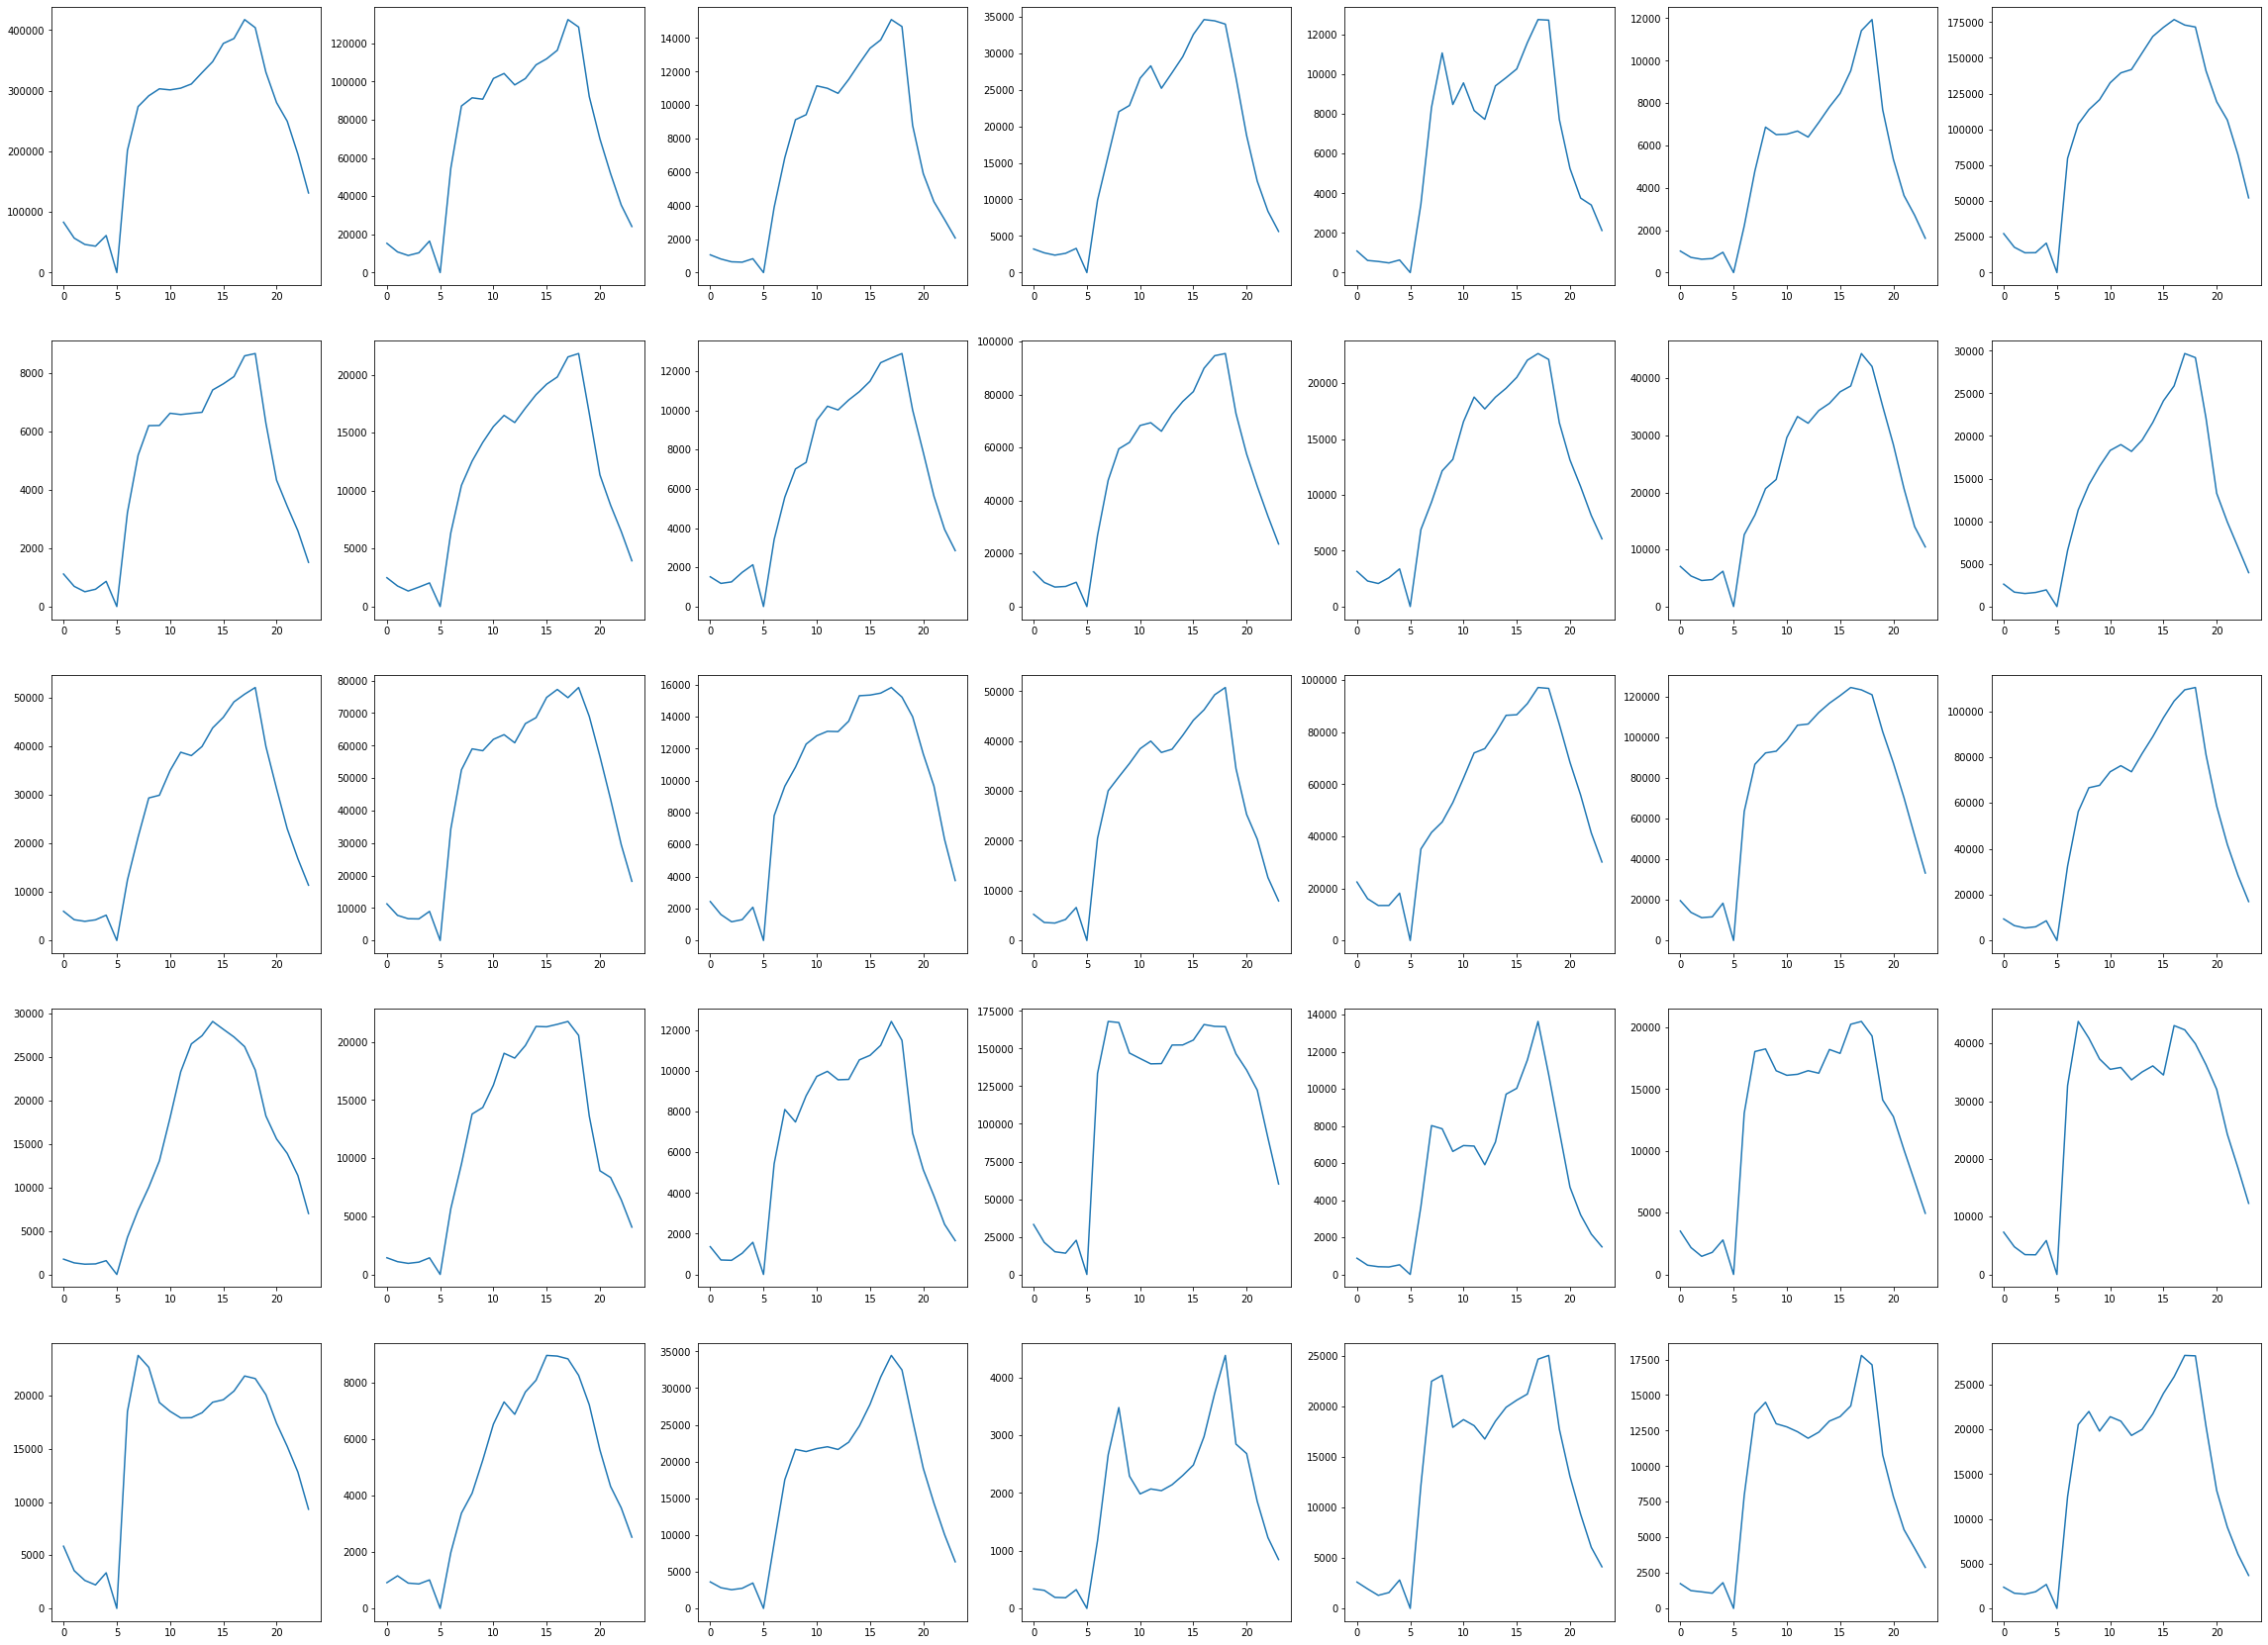

In [232]:
fig, axes = plt.subplots(5,7, figsize=(40,30))
for i in range(len(df_col[2:])) :
    axes[i//7][i%7].plot(df[df_col[1]].iloc[3207:3231],df[df_col[i+2]].iloc[3207:3231])
plt.show()

In [309]:
print(f'Train Dataset : {len(train_dataset)}, Valid Dataset : {len(valid_dataset)}')

Train Dataset : 4270, Valid Dataset : 35


In [310]:
for sample in train_dataloader :
    input_data, output_data = sample
    print(input_data.shape,output_data.shape)
    break

torch.Size([64, 168]) torch.Size([64, 168])


In [327]:
model = LSTM(input_size=input_size, hidden_dim=hidden_dim, output_size=output_size, batch_size=batch_size, num_layers=num_layers).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler =  torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=1e-4, epochs=num_epochs, steps_per_epoch=len(train_dataloader))

In [21]:
print(model)

NBeats(
  (rnn1): LSTM(1, 1024, num_layers=4, batch_first=True, dropout=0.3)
  (rnn2): LSTM(1024, 1024, num_layers=4, batch_first=True, dropout=0.3)
  (activation): LeakyReLU(negative_slope=0.2)
  (out): Linear(in_features=1024, out_features=168, bias=True)
)


In [329]:
train_batch_loss = []
train_epoch_loss = []

valid_epoch_loss = []
valid_min_epoch_loss = np.inf
for epoch in tqdm(range(num_epochs)) :
    model.train()

    for i, sample in enumerate(train_dataloader) :

        input_data, output_data = sample

        input_data = input_data.unsqueeze(2).to(device)
        output_data = output_data.unsqueeze(2).to(device)

        pred, (h_out, c_out) = model(input_data)
        loss = criterion(pred, output_data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_batch_loss.append(loss.item())
        train_epoch_loss.append(loss.item())

        if i % 400 == 399:      # 400개의 batch마다 training Loss 출력
            print('Train Epoch: {:2} | Batch: {:4} | Loss: {:1.2f}'.format(epoch+1, i+1, np.array(train_batch_loss).mean()))
            train_batch_loss = []

    print(f'Train Epoch_Loss: {np.array(train_epoch_loss).mean()}')
    train_epoch_loss = []

    model.eval()      # 모델을 eval mode로 전환. eval mode에서 적용되면 안되는 drop out 등이 적용되지 않게 하기 위함

    with torch.no_grad():      # validation / test set에 대해서는 weight 및 bias의 update, 즉, gradient descent가 일어나지 않도록 no_grad()를 선언

        for i, sample in enumerate(valid_dataloader):      # enumerate 함수를 통해 validate_dataloader에서 'batch의 index'와 'batch'를 순서대로 호출

            input_data, output_data = sample      # validate_dataloader에서 불러온 sample은 [[날짜, 시간], [도로], [[input_data],[output_data]]]로 구성됨. validation에는 [[input_data], [output_data]]만 사용

            input_data = input_data.unsqueeze(2).to(device)
            output_data = output_data.unsqueeze(2).to(device)

            pred, (h_in, c_in) = model(input_data)
            loss = criterion(pred, output_data)
            valid_epoch_loss.append(loss.item())

        print('\nValid Epoch: {:2} | Loss: {:1.2f}'.format(epoch+1, np.array(valid_epoch_loss).mean()))

        if np.array(valid_epoch_loss).mean() < valid_min_epoch_loss:
            save_model('rnn_v001', model, optimizer)
            valid_min_epoch_loss = np.array(valid_epoch_loss).mean()

        valid_epoch_loss = []

  0% 0/20 [00:00<?, ?it/s]

Train Epoch_Loss: 0.9847916129863623

Valid Epoch:  1 | Loss: 0.97


  5% 1/20 [01:39<31:22, 99.08s/it]

model saved

Train Epoch_Loss: 0.3988434880068808

Valid Epoch:  2 | Loss: 0.23


 10% 2/20 [03:18<29:43, 99.07s/it]

model saved

Train Epoch_Loss: 0.26056991743318964

Valid Epoch:  3 | Loss: 0.21


 15% 3/20 [04:57<28:06, 99.20s/it]

model saved

Train Epoch_Loss: 0.24948417643706003

Valid Epoch:  4 | Loss: 0.21


 20% 4/20 [06:37<26:28, 99.31s/it]

model saved

Train Epoch_Loss: 0.24223519342415262

Valid Epoch:  5 | Loss: 0.20


 25% 5/20 [08:16<24:51, 99.41s/it]

model saved

Train Epoch_Loss: 0.23782989224701218


 30% 6/20 [09:51<22:51, 97.96s/it]


Valid Epoch:  6 | Loss: 0.20
Train Epoch_Loss: 0.23319541346846204

Valid Epoch:  7 | Loss: 0.19


 35% 7/20 [11:31<21:22, 98.63s/it]

model saved

Train Epoch_Loss: 0.23015714956052374


 40% 8/20 [13:06<19:29, 97.44s/it]


Valid Epoch:  8 | Loss: 0.20


 40% 8/20 [13:14<19:51, 99.33s/it]


KeyboardInterrupt: 

In [387]:
submission_file_path = os.path.join(data_dir,'sample_submission.csv')
submission_table = pd.read_csv(submission_file_path)

In [314]:
test_dataset = CustomDataset(data_dir=data_dir, mode='test', scaler=scaler, seq_len=seq_len)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [332]:
model_path = 'rnn_v001.pt'

In [337]:
model = LSTM(input_size=input_size, hidden_dim=hidden_dim, output_size=output_size, batch_size=batch_size, num_layers=num_layers).to(device)

In [338]:
state = torch.load(os.path.join('log',model_path))
model.load_state_dict(state['model'])

<All keys matched successfully>

In [388]:
pred_lst = []

model.eval()
with torch.no_grad():
    for sample in test_dataloader :
        input_data = sample.unsqueeze(2).to(device)
        pred, (h_out, c_out) = model(input_data)
        pred_lst.append(pred.squeeze(0).squeeze(1).cpu().numpy())

In [343]:
len(pred_lst)

35

In [389]:
sub_col = submission_table.columns.values

In [390]:
for i in range(len(pred_lst)) :
    submission_table[sub_col[i+1]] = pred_lst[i]

In [391]:
submission_table[sub_col[1:]] = scaler.inverse_transform(submission_table[sub_col[1:]])

In [364]:
submission_table.to_csv('v001_submission.csv',index=False)

In [392]:
submission_table.head()

timestamp            10           100         101          120  \
0  20200525_0  87085.976562  19894.574219  805.023621  3292.015381   
1  20200525_1  75305.492188  15799.312500  259.868347  1943.380493   
2  20200525_2  68482.070312  12812.960938 -119.701477   781.243774   
3  20200525_3  70106.226562  12699.488281 -118.693665   558.456665   
4  20200525_4  84547.992188  17229.191406  491.402039  1884.240845   

          121         140           150          160          200  ...  \
0  937.442688  590.404602  32020.808594  1222.845825  3011.362305  ...   
1  472.457336  247.279327  26355.980469   940.245483  2093.897461  ...   
2  214.654114   25.978064  22591.019531   726.847534  1166.295044  ...   
3  278.214172   42.402382  22759.292969   711.619019   876.642639  ...   
4  848.417786  439.652374  29381.066406  1018.256714  1640.660278  ...   

         1020         1040          1100         1200        1510  \
0  664.936218  3671.935303  13704.485352  6259.940430  659.890808   
1  290.694519  3080.825439  11787.395508  5447.044922  243.336609   
2   45.560734  2718.243896  10851.654297  5051.136719 -131.724426   
3   61.190128  2769.785889  11113.580078  5206.840820 -216.550110   
4  498.083191  3483.046631  12799.201172  6095.666504  178.684265   

          2510        3000         4510         5510         6000  
0  3620.605957  589.068604  2529.968018  1846.833252  3196.201172  
1  2694.960449  367.067352  1734.927002  1344.614502  2299.075195  
2  2074.293457  264.484100  1339.850830  1035.366943  1720.407349  
3  2099.116699  310.940155  1520.149658  1073.923584  1764.949341  
4  3178.576660  542.051270  2551.912354  1672.745850  2816.218750  

[5 rows x 36 columns]

In [393]:
df_valid['timestamp'] = [str(a)+'_'+str(b) for a, b in zip(df_valid['날짜'],df_valid['시간'])]

In [395]:
df_valid = df_valid[np.append(df_valid.columns.values[-1],df_valid.columns.values[2:-1])]

In [367]:
submission_table['날짜'] = [s[:8] for s in submission_table['timestamp']]

In [369]:
submission_table['시간'] = [s[9:] for s in submission_table['timestamp']]

In [372]:
submission_table = submission_table[np.append(submission_table.columns.values[-2:],submission_table.columns.values[1:-2])]

In [396]:
df_plot = pd.concat([df_valid,submission_table])

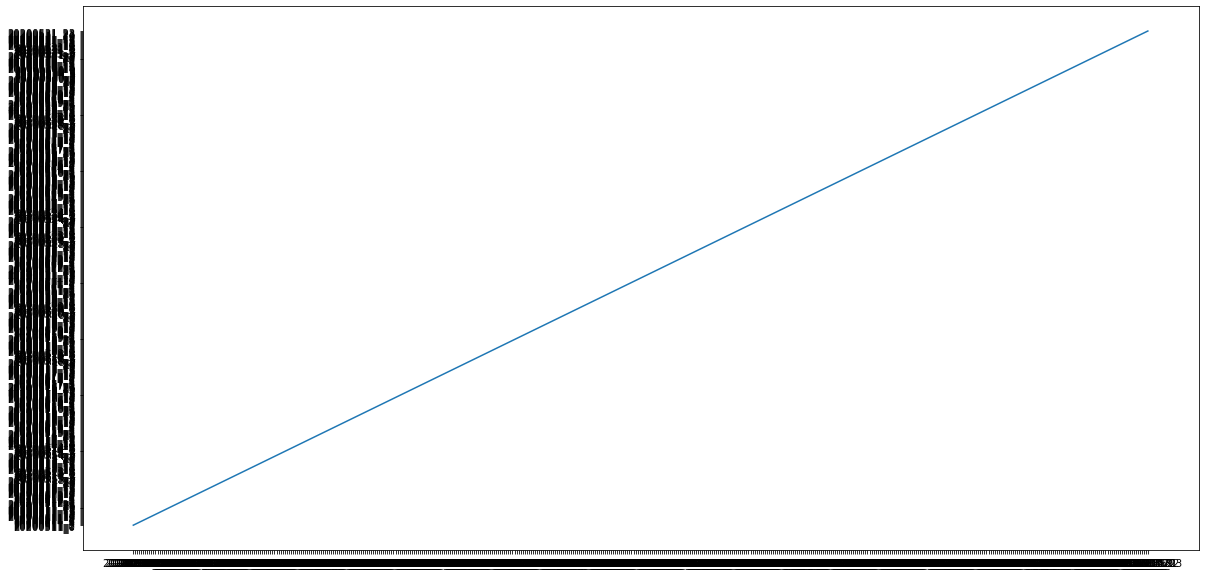

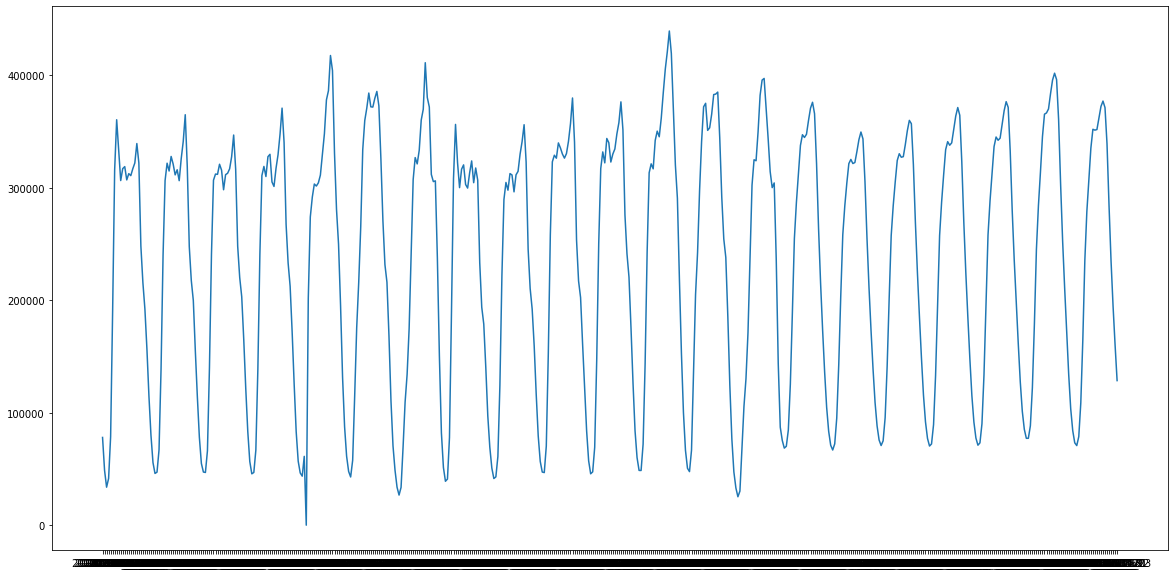

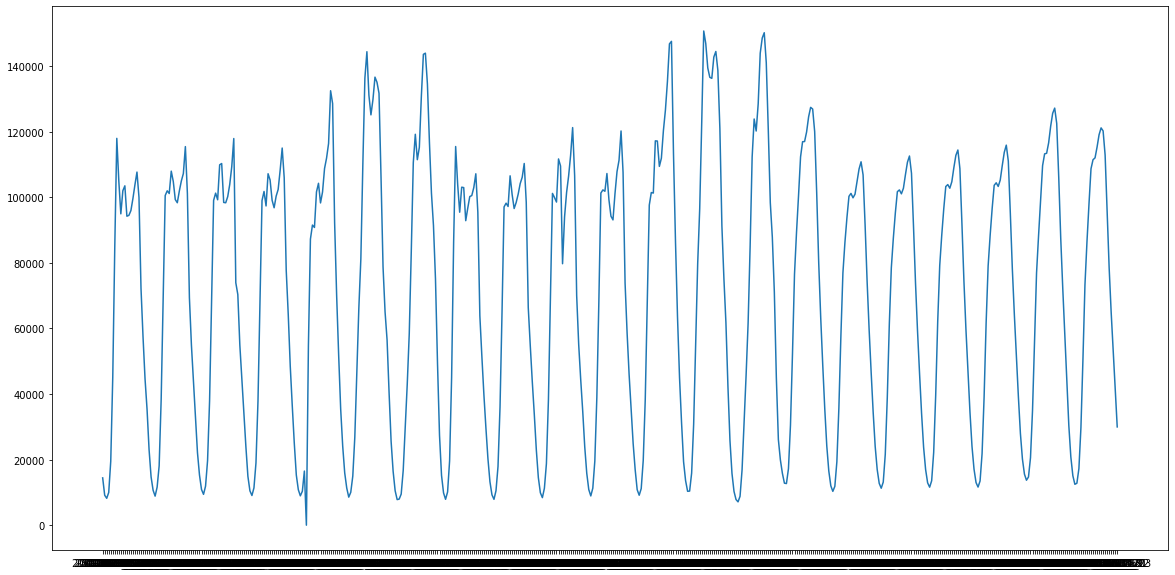

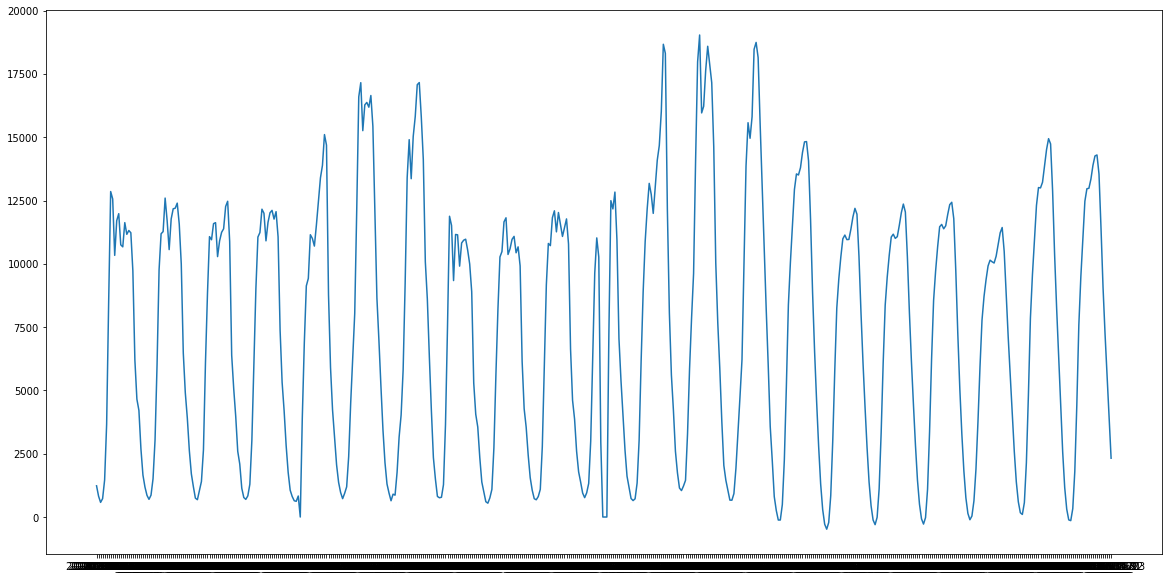

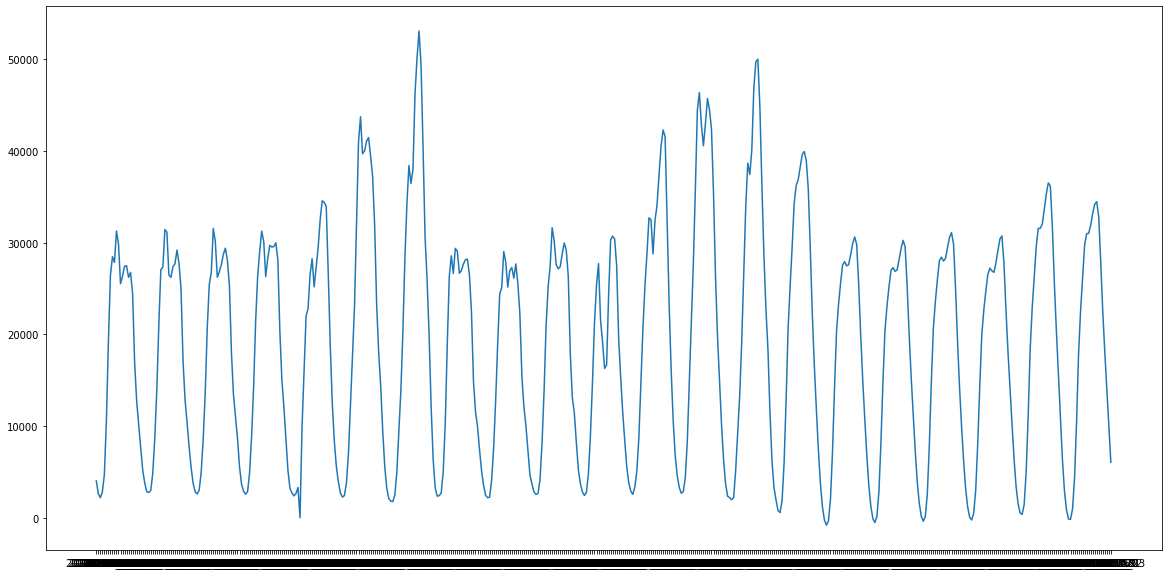

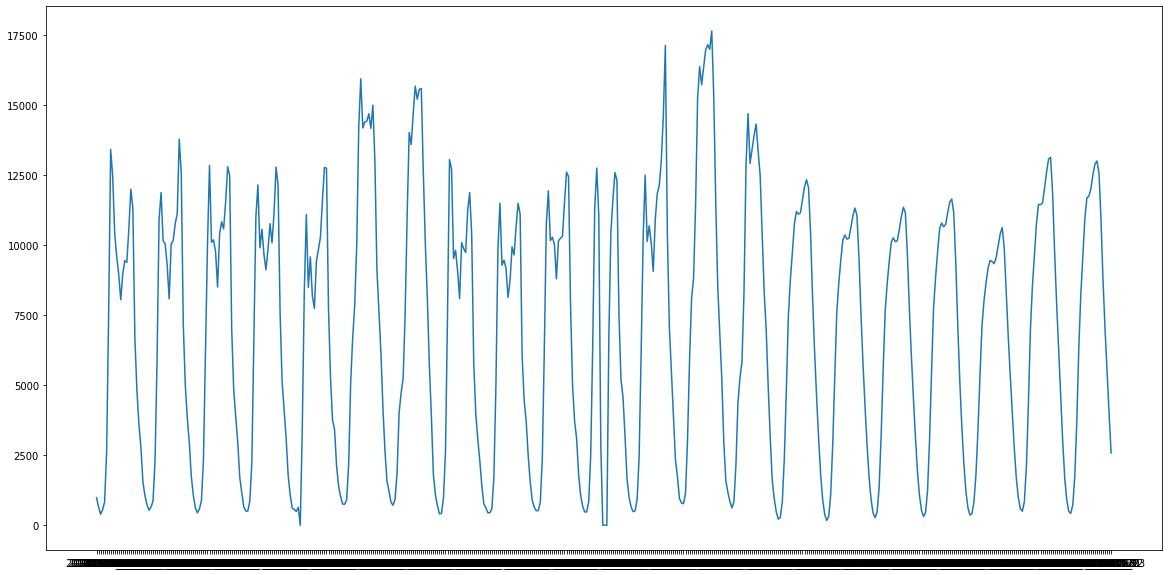

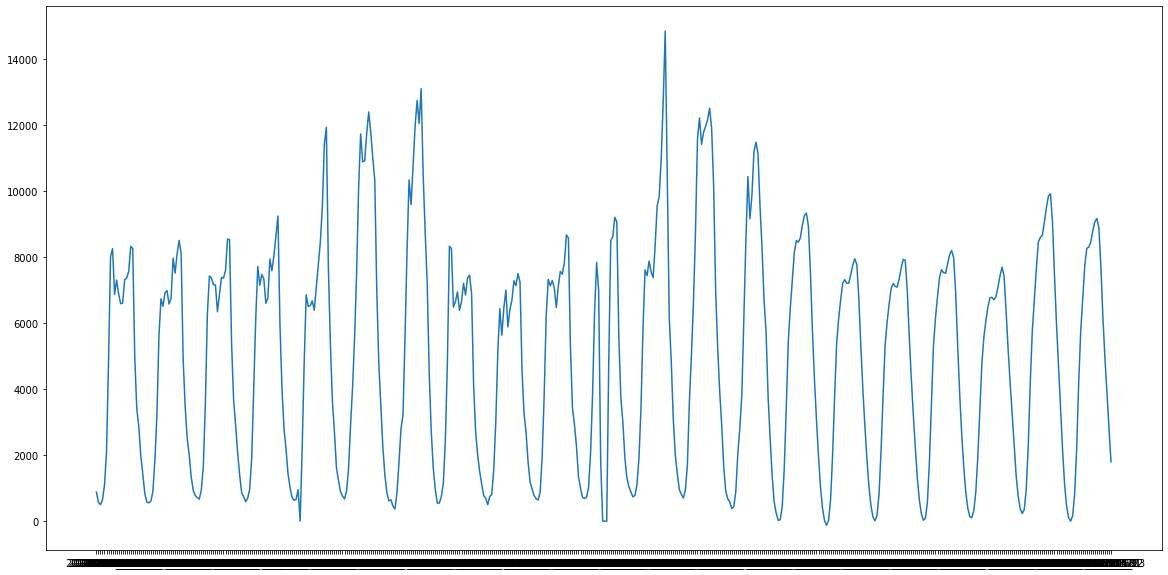

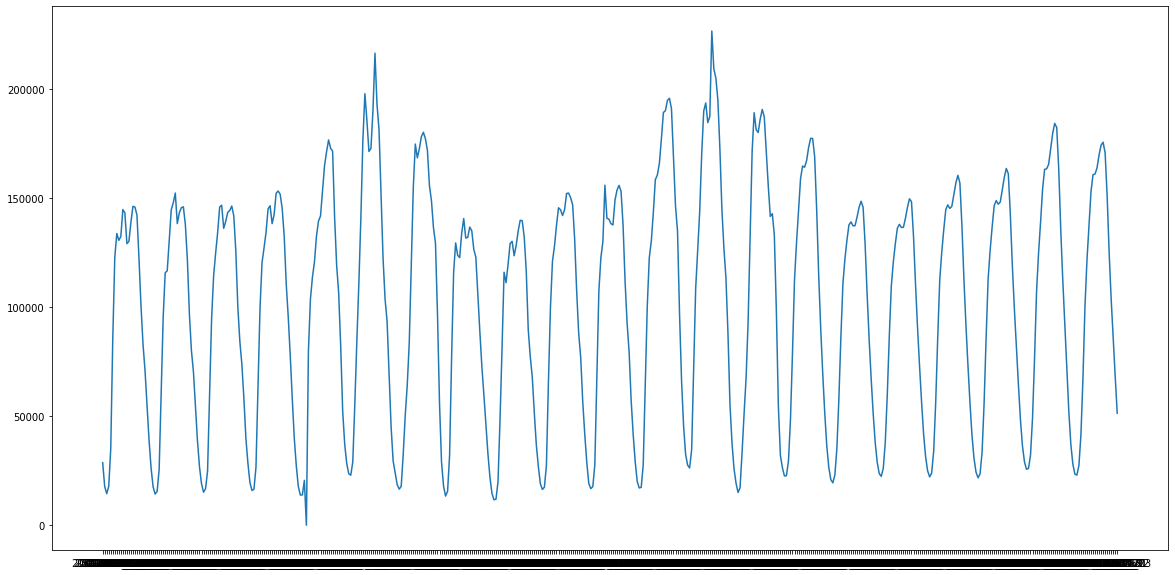

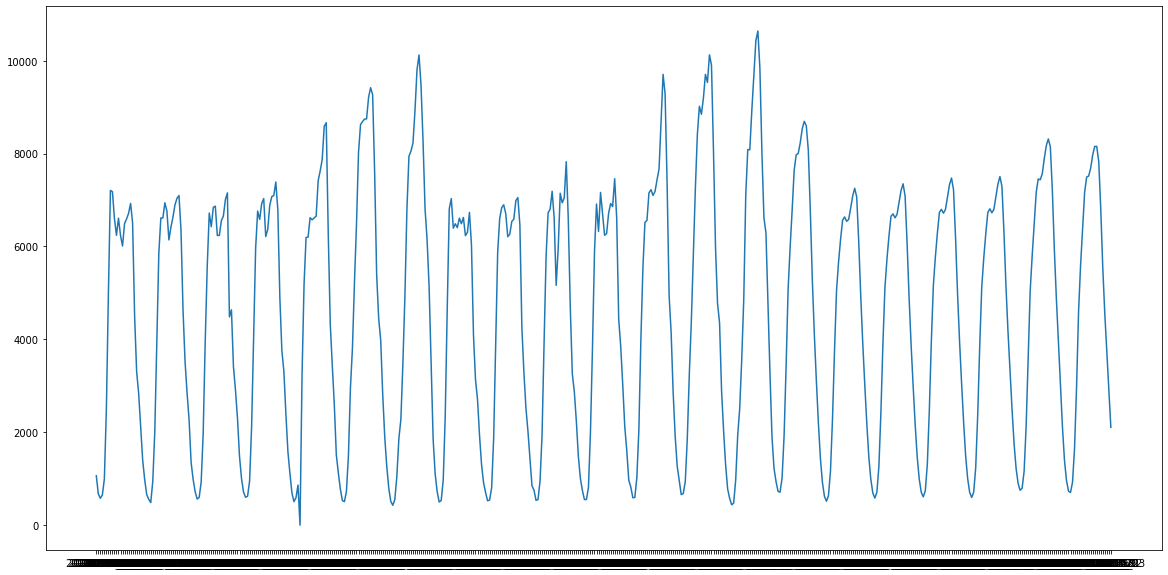

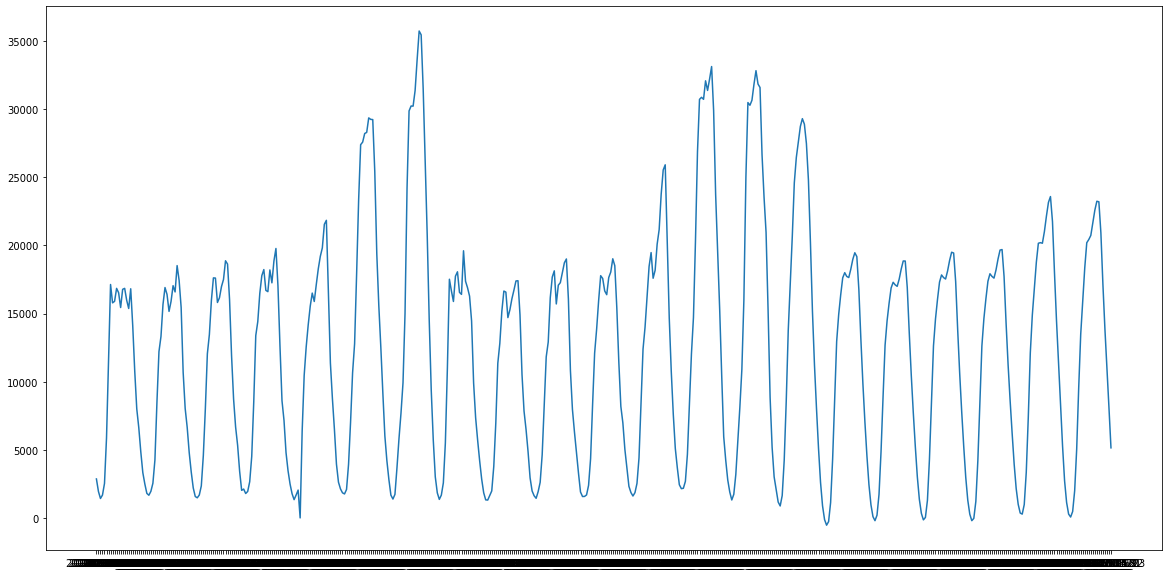

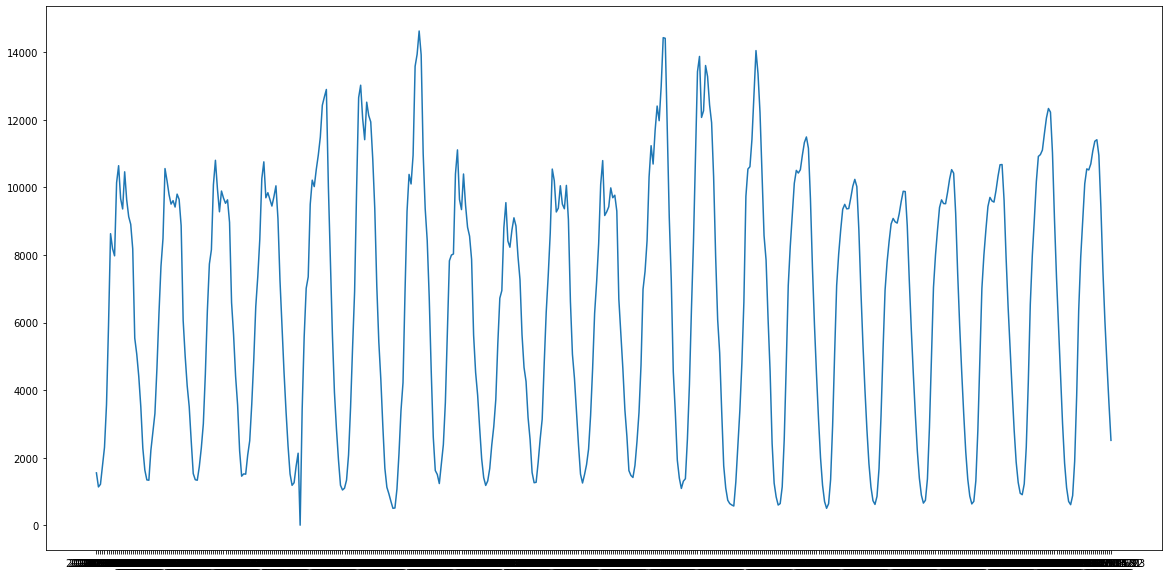

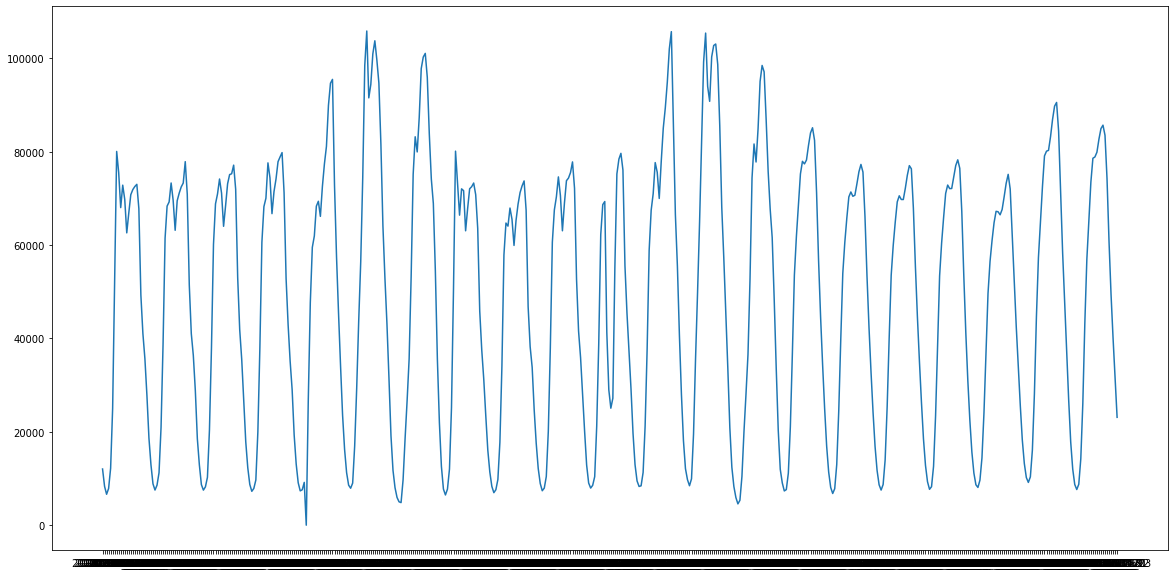

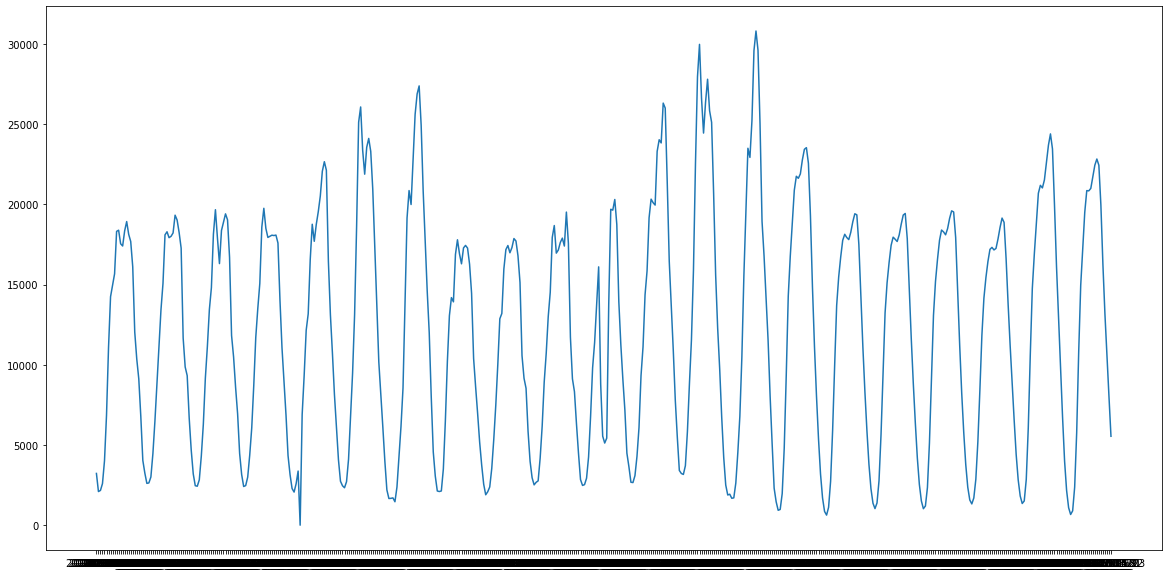

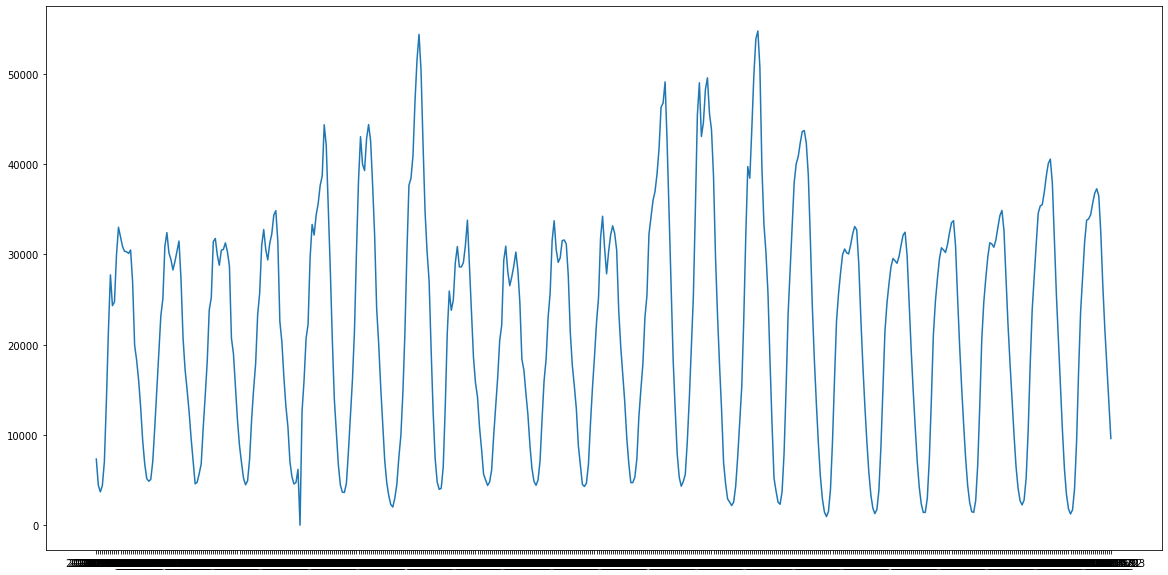

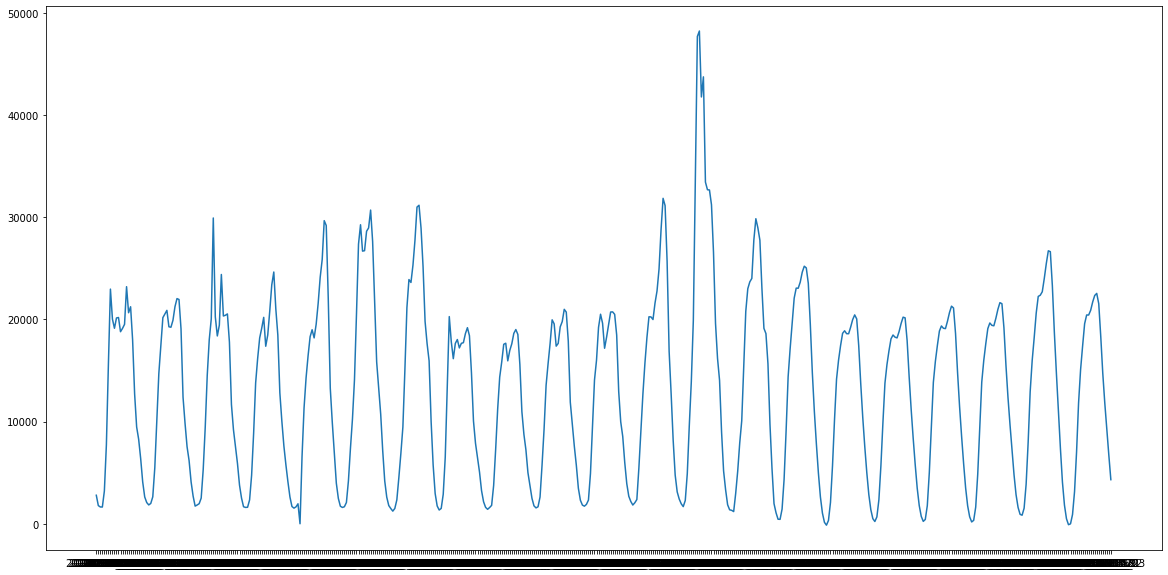

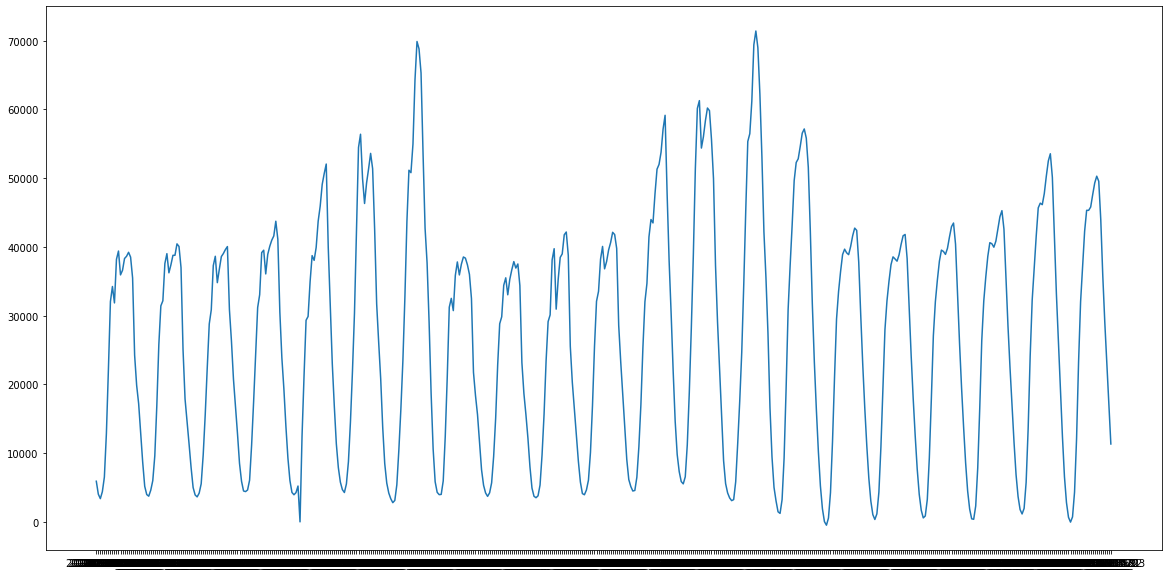

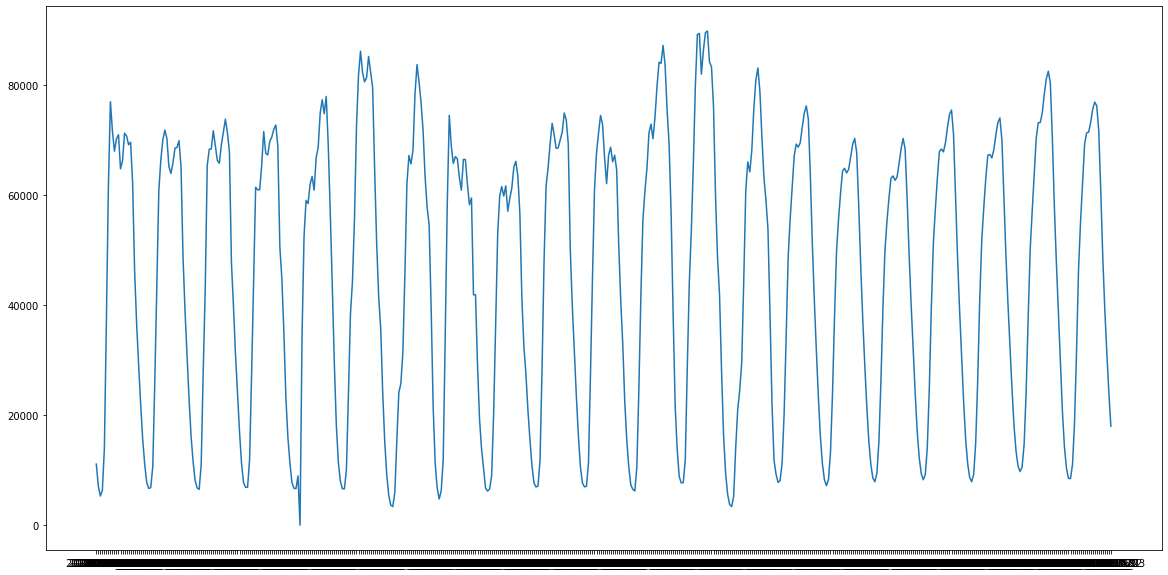

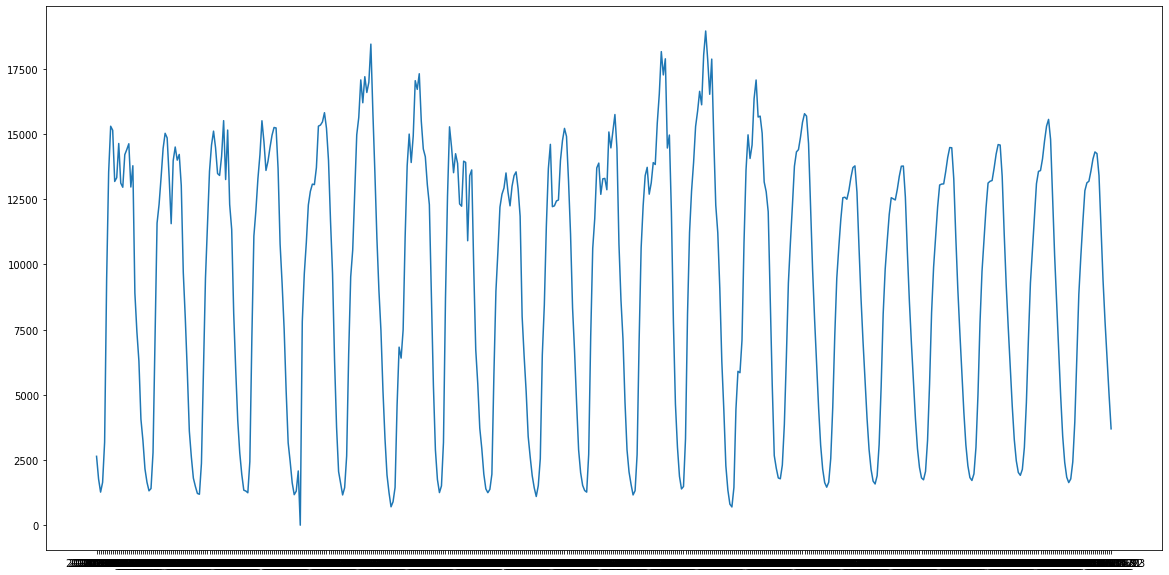

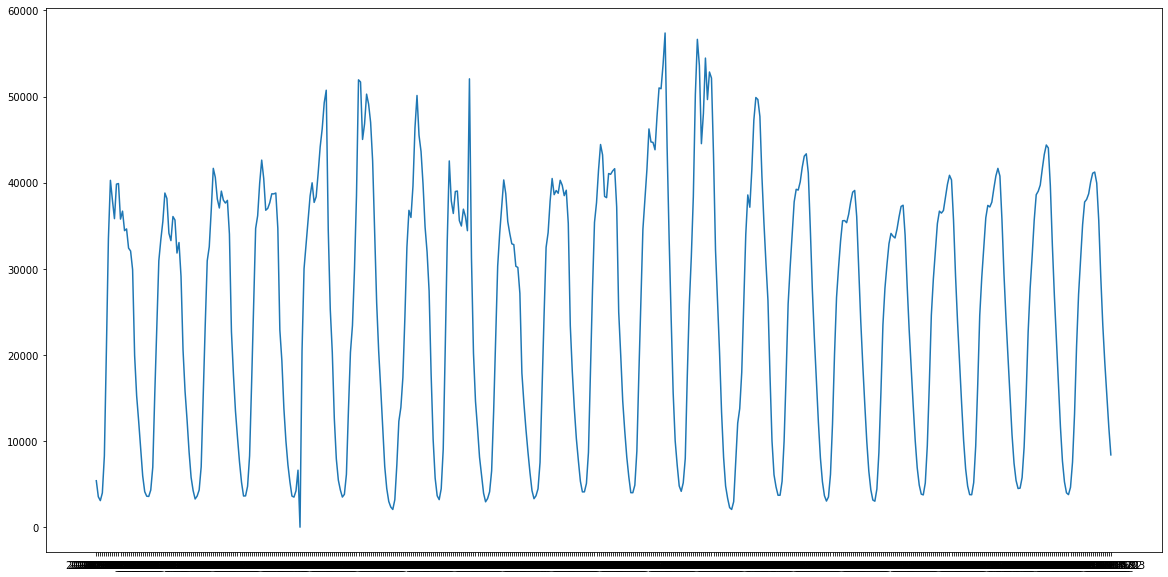

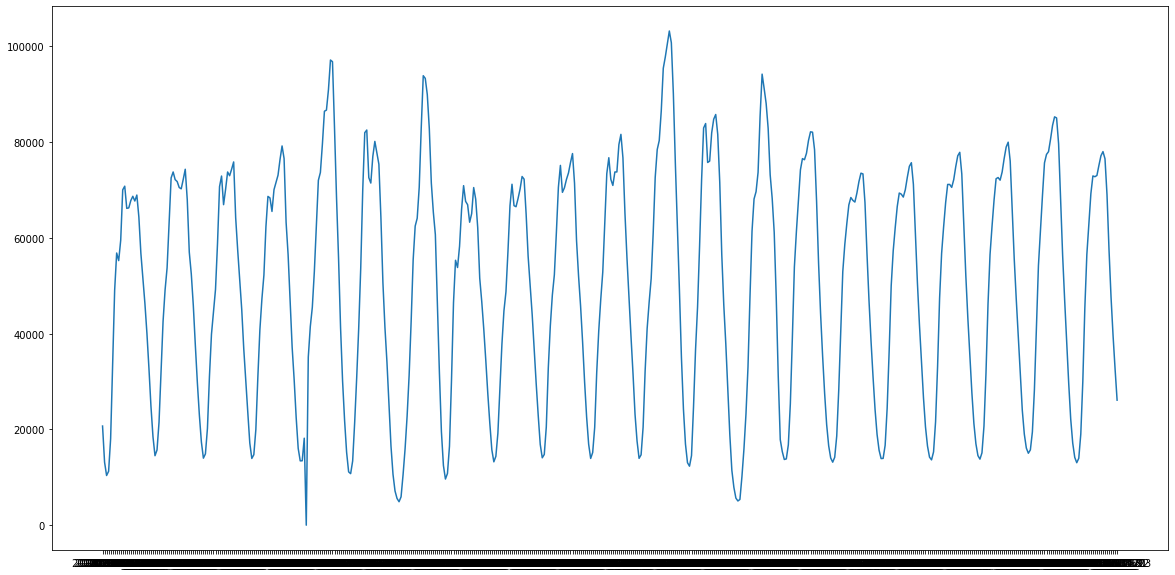

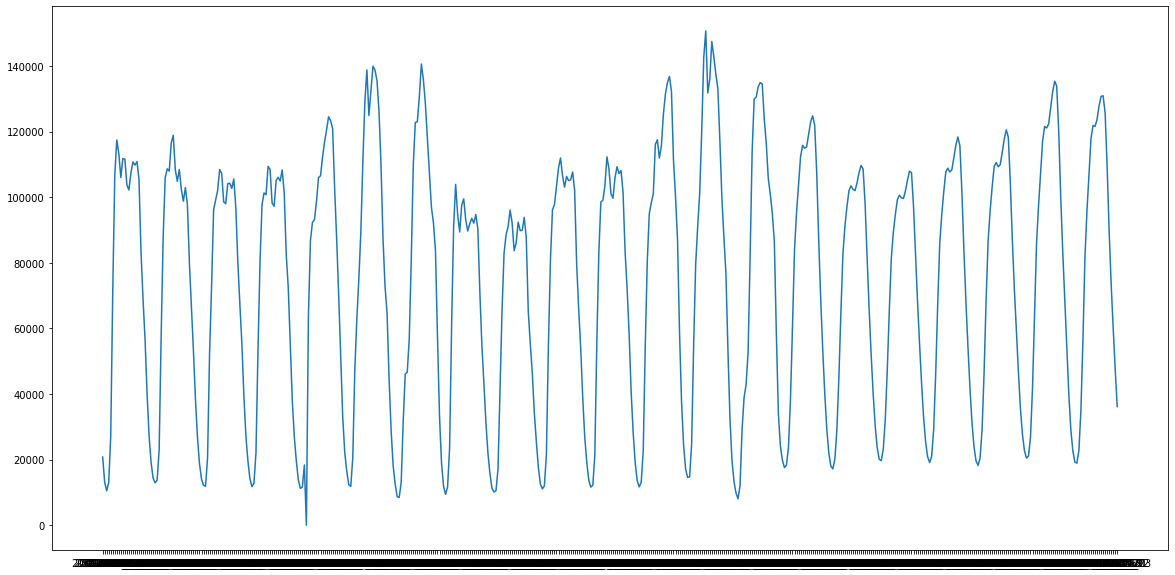

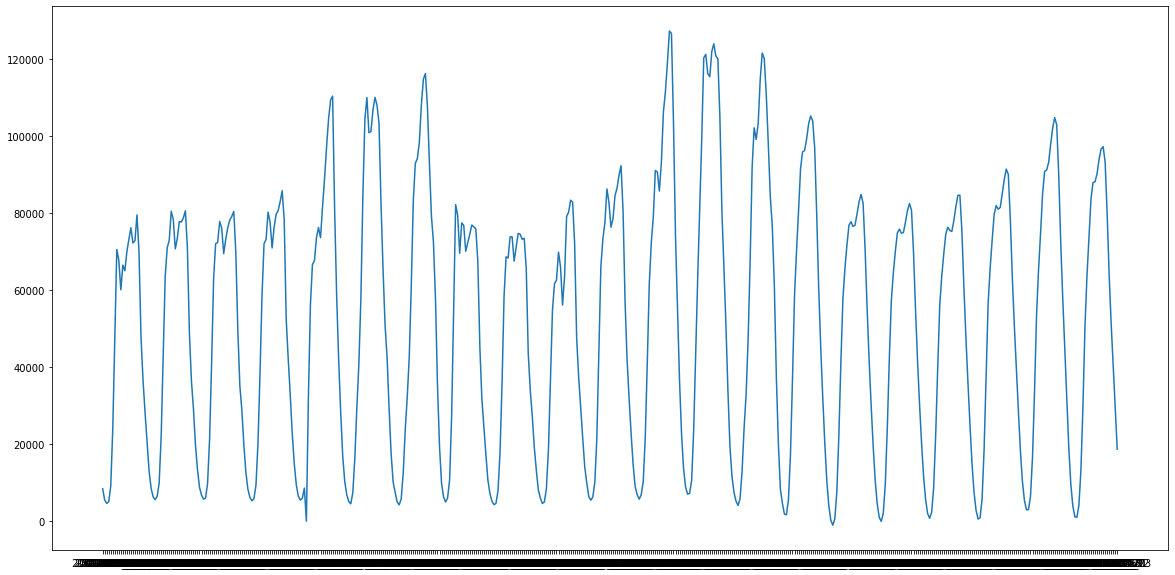

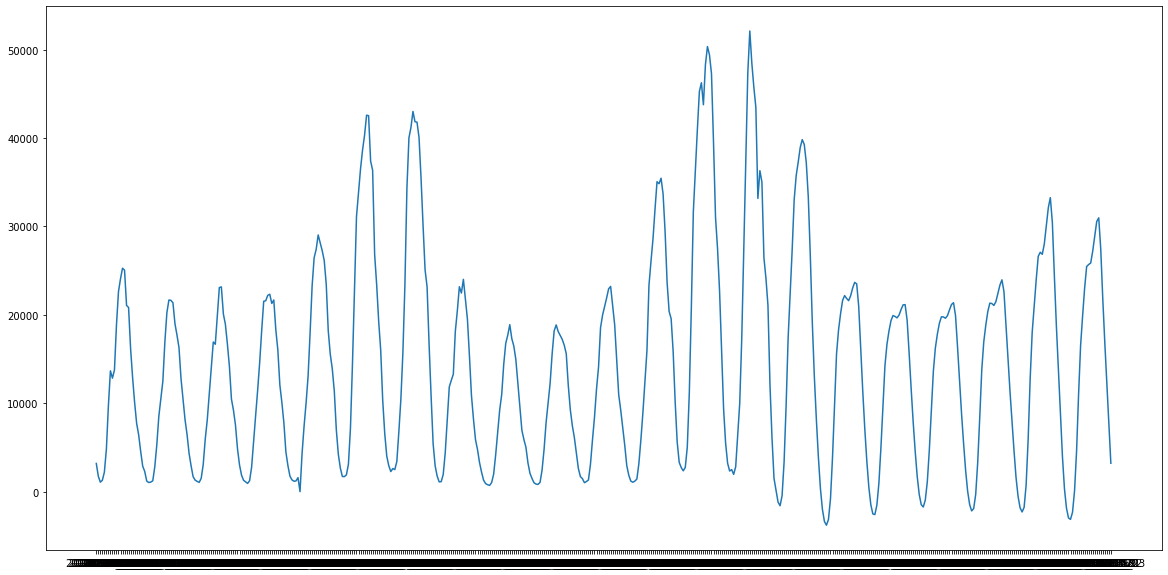

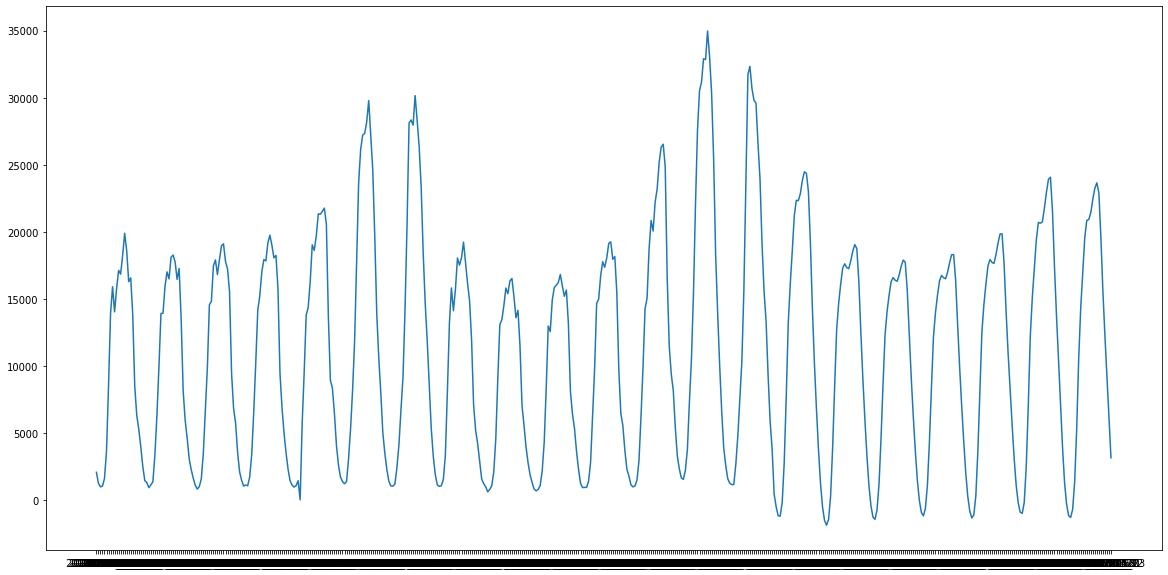

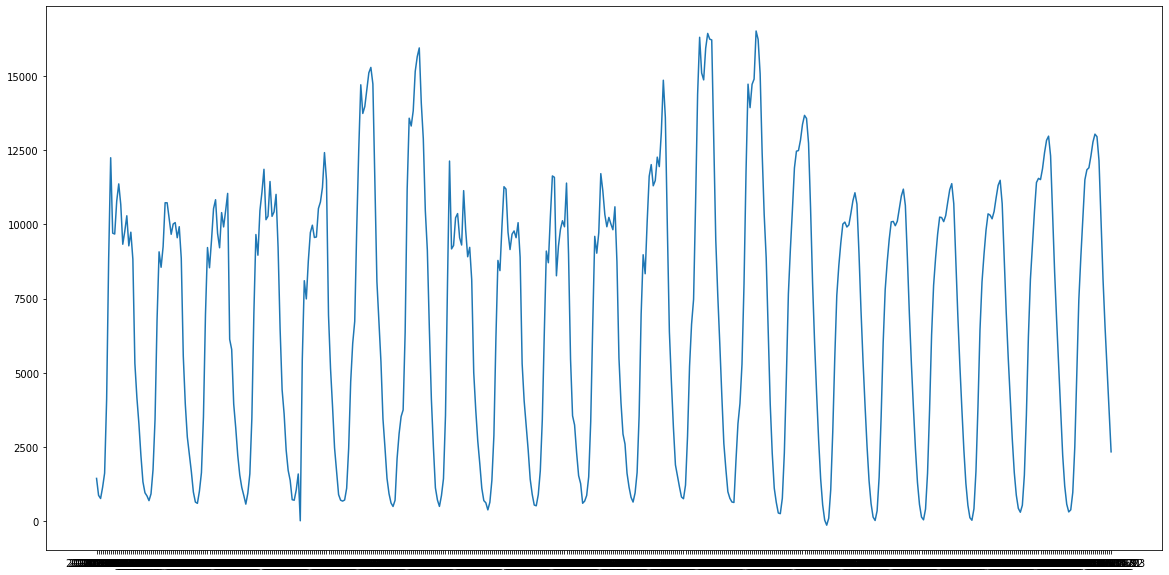

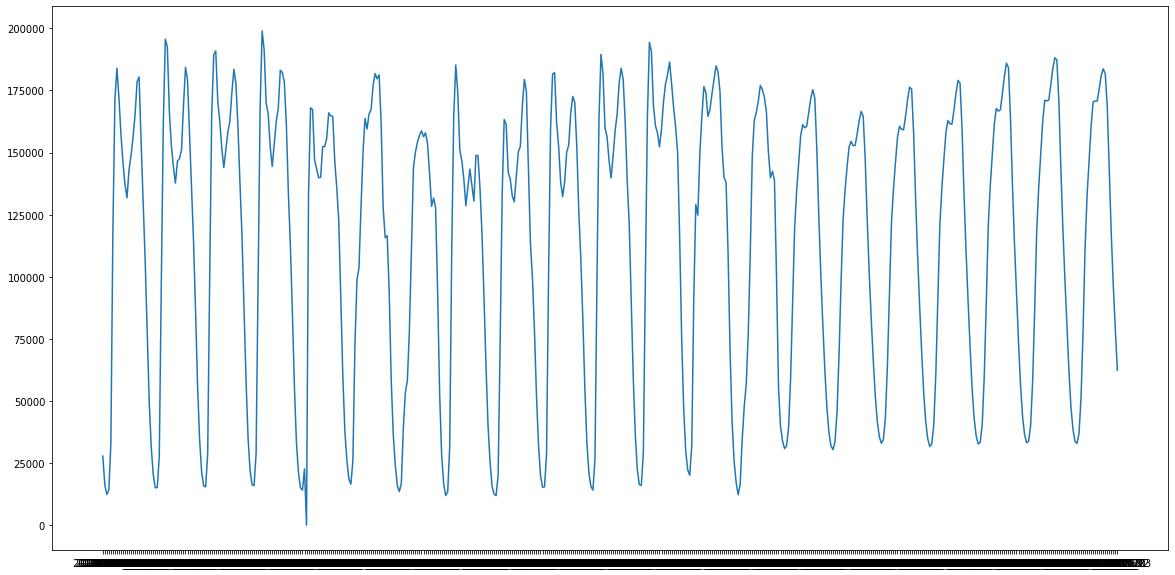

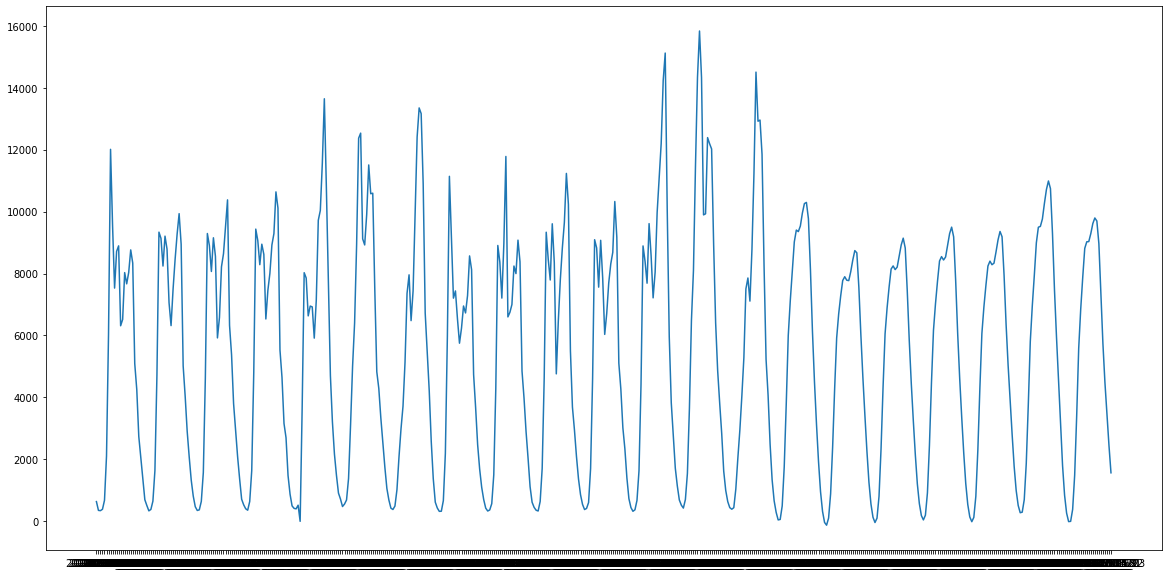

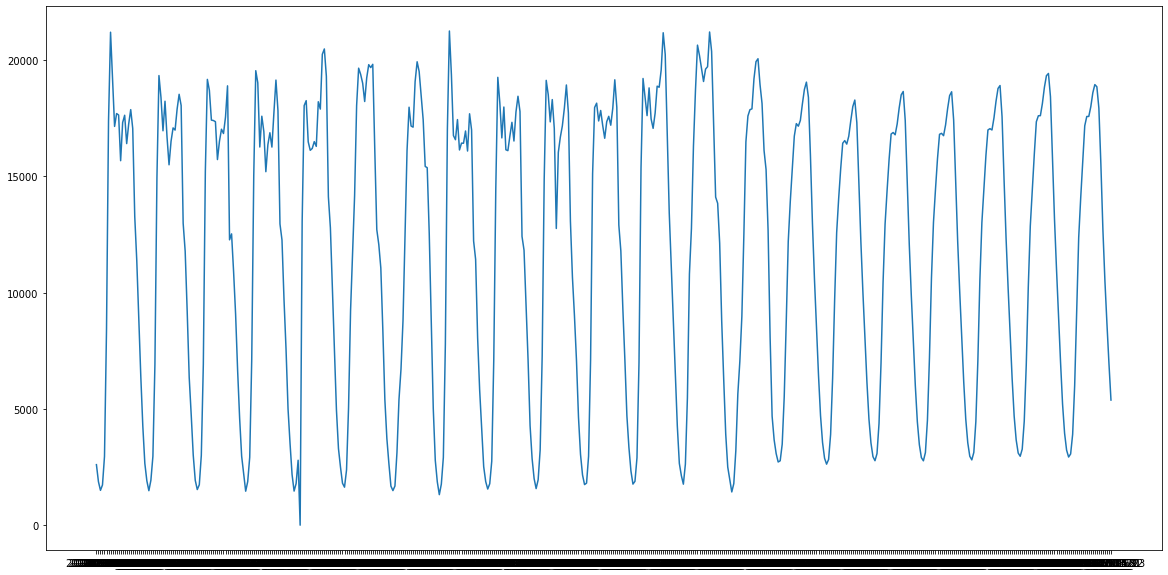

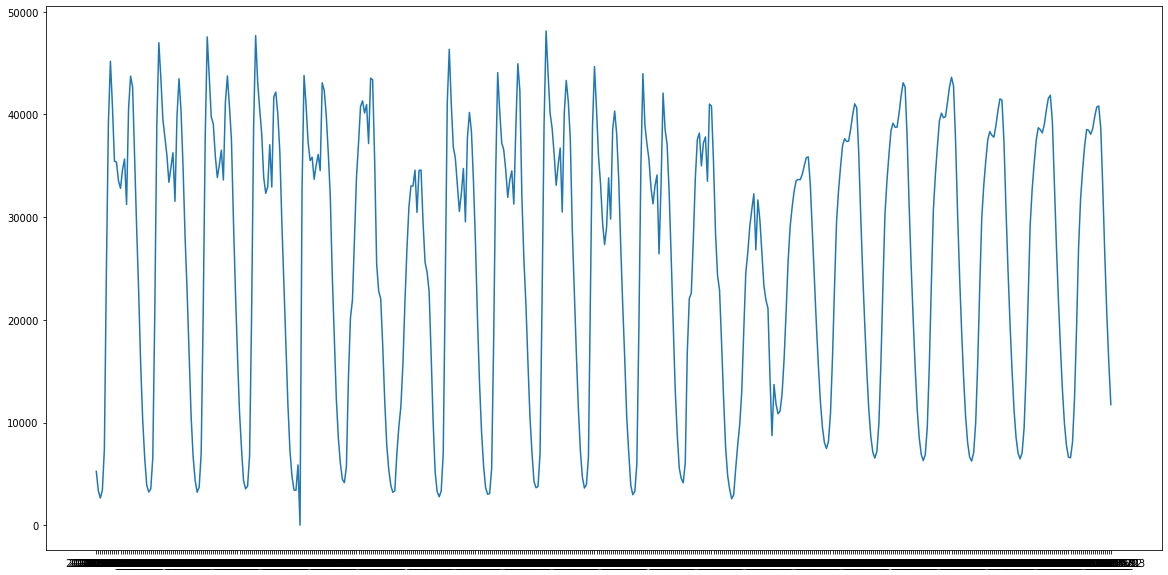

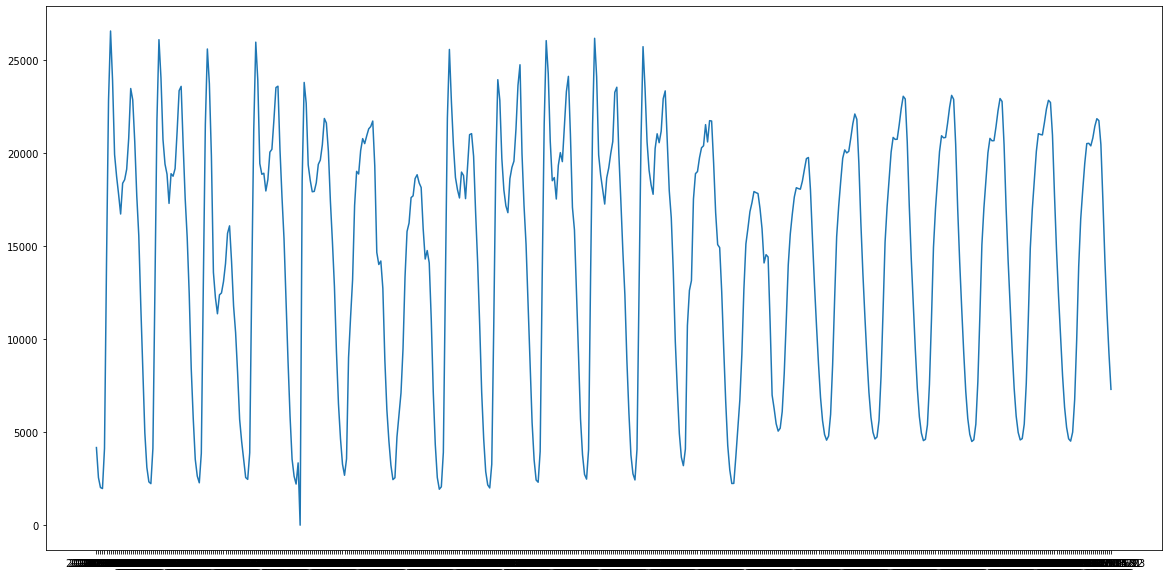

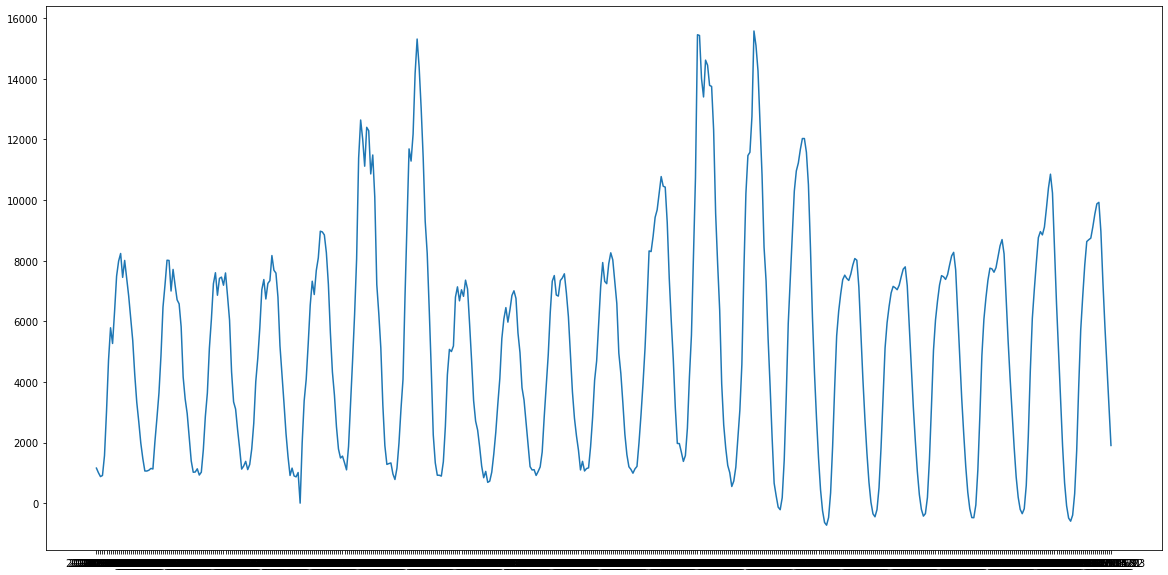

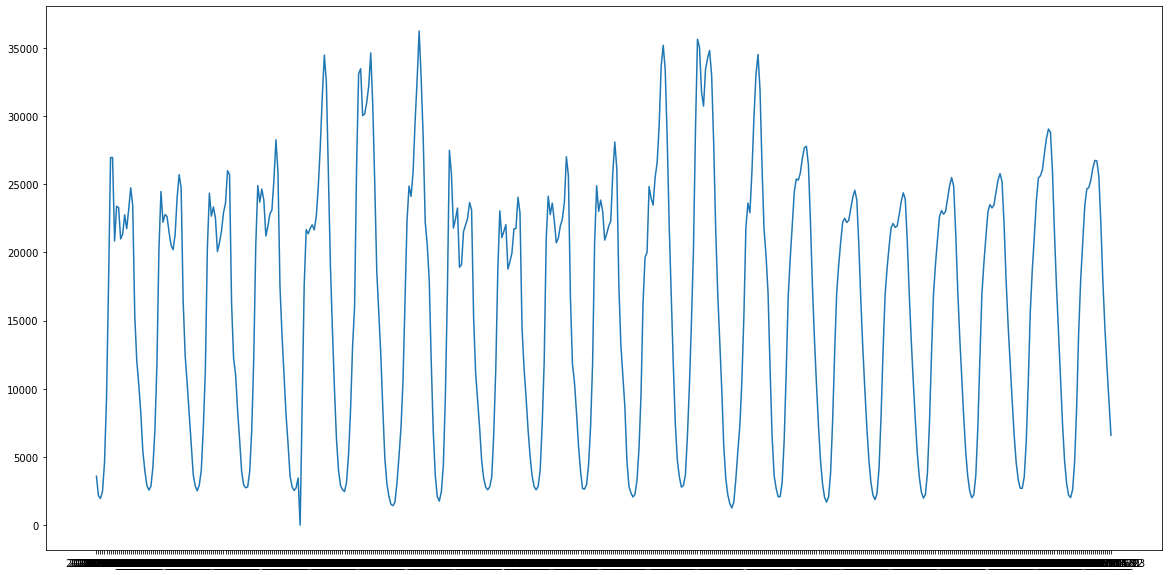

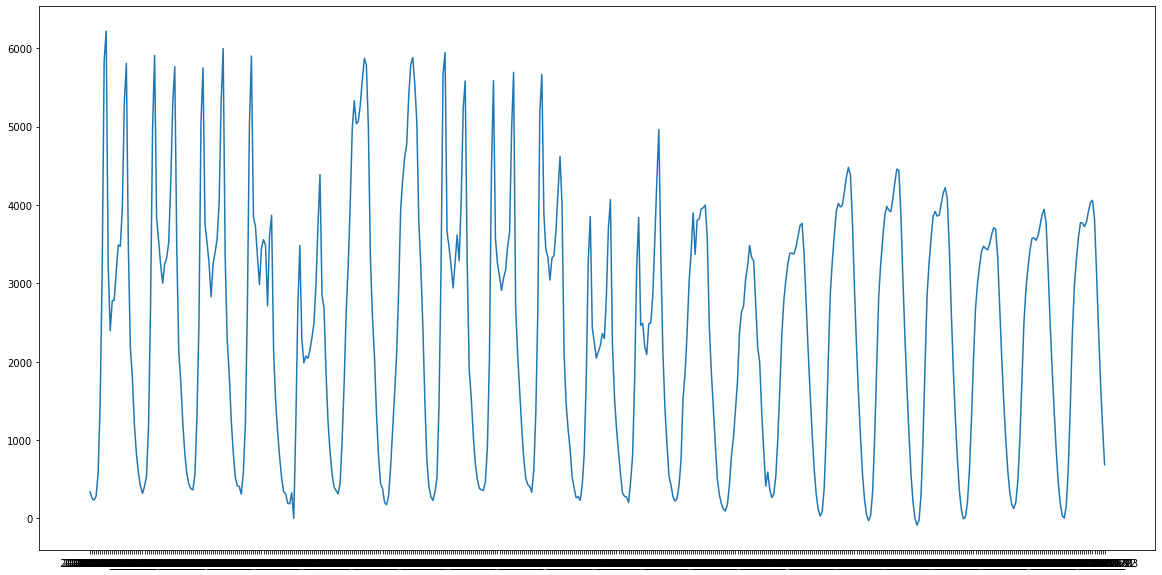

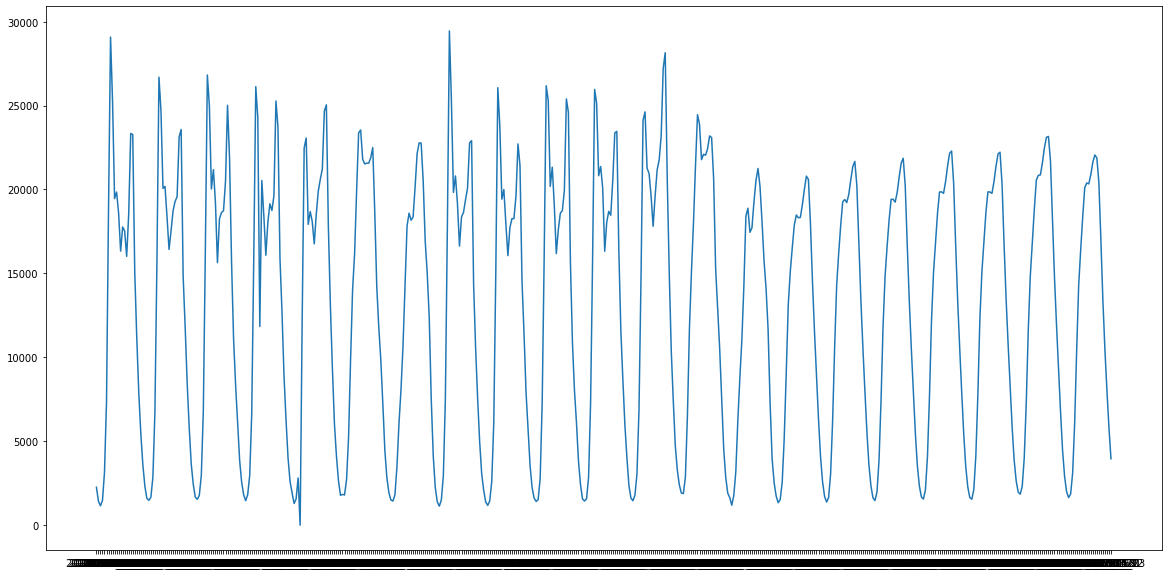

In [397]:
for i in range(len(df_plot.columns.values[2:])) :
    plt.figure(figsize=(20,10))
    plt.plot(df_plot['timestamp'],df_plot[df_plot.columns.values[i]])
    plt.show()

In [362]:
df_valid = pd.read_csv(os.path.join(data_dir,'valid.csv'))

In [363]:
df_valid

날짜  시간      10    100    101    120   121   140     150   160  ...  \
0    20200511   0   77968  14429   1233   4021   981   881   28672  1064  ...   
1    20200511   1   48679   9136    823   2618   654   572   17722   672  ...   
2    20200511   2   33773   8199    578   2188   392   502   14464   579  ...   
3    20200511   3   41511   9986    726   2817   555   646   17793   650  ...   
4    20200511   4   78680  19509   1463   4720   825  1088   35125   997  ...   
..        ...  ..     ...    ...    ...    ...   ...   ...     ...   ...  ...   
331  20200524  19  314226  98345  10625  28618  8316  6684  141675  6619  ...   
332  20200524  20  300001  87871   8226  22706  6981  5743  142933  6295  ...   
333  20200524  21  304150  71126   6002  18317  4939  3779  133110  4781  ...   
334  20200524  22  236751  44947   3575  11455  3135  2536   98582  3267  ...   
335  20200524  23  143609  26137   2242   6166  1609  1391   54633  1899  ...   

     1020   1040   1100   1200  1510   2510  3000   4510   5510   6000  
0     637   2604   5239   4168  1155   3596   337   2262   1608   2337  
1     353   1870   3359   2558  1002   2157   257   1425   1018   1810  
2     345   1499   2646   2022   876   1959   232   1155    927   1530  
3     390   1730   3398   1967   912   2462   281   1477    959   1882  
4     679   2958   7369   4120  1569   4568   577   3155   1871   3656  
..    ...    ...    ...    ...   ...    ...   ...    ...    ...    ...  
331  8254  16118  23304  14082  8447  21694  2180  15746  10903  21014  
332  5225  15297  21919  14526  7332  19732  1990  14096  10028  17787  
333  4072  12685  21135  14403  5443  16967  1359  11670   7963  14041  
334  2489   8093  14427  10914  3861  11397   859   7270   5194   8230  
335  1343   4686   8732   6986  2161   6487   410   3963   2686   4690  

[336 rows x 37 columns]

In [378]:
df_plot

날짜  시간            10           100          101           120  \
0    20200511   0   77968.00000  14429.000000  1233.000000   4021.000000   
1    20200511   1   48679.00000   9136.000000   823.000000   2618.000000   
2    20200511   2   33773.00000   8199.000000   578.000000   2188.000000   
3    20200511   3   41511.00000   9986.000000   726.000000   2817.000000   
4    20200511   4   78680.00000  19509.000000  1463.000000   4720.000000   
..        ...  ..           ...           ...          ...           ...   
163  20200531  19  284030.25000  78481.937500  9079.876953  22409.330078   
164  20200531  20  234788.03125  64912.386719  7230.471191  18069.400391   
165  20200531  21  194660.78125  53068.792969  5588.216797  14114.067383   
166  20200531  22  160223.15625  41123.078125  3910.192139   9984.976562   
167  20200531  23  128489.18750  29973.957031  2322.502686   6052.648926   

             121          140            150          160  ...         1020  \
0     981.000000   881.000000   28672.000000  1064.000000  ...   637.000000   
1     654.000000   572.000000   17722.000000   672.000000  ...   353.000000   
2     392.000000   502.000000   14464.000000   579.000000  ...   345.000000   
3     555.000000   646.000000   17793.000000   650.000000  ...   390.000000   
4     825.000000  1088.000000   35125.000000   997.000000  ...   679.000000   
..           ...          ...            ...          ...  ...          ...   
163  8731.904297  6190.179688  124982.632812  5542.464844  ...  5743.830566   
164  6989.287109  4950.379395  103731.601562  4551.868164  ...  4486.536133   
165  5487.268066  3884.322510   85697.296875  3721.429688  ...  3447.943115   
166  4002.586182  2829.572510   68224.625000  2907.523438  ...  2456.779785   
167  2579.199951  1798.311768   51331.277344  2105.727539  ...  1566.387451   

             1040          1100          1200         1510          2510  \
0     2604.000000   5239.000000   4168.000000  1155.000000   3596.000000   
1     1870.000000   3359.000000   2558.000000  1002.000000   2157.000000   
2     1499.000000   2646.000000   2022.000000   876.000000   1959.000000   
3     1730.000000   3398.000000   1967.000000   912.000000   2462.000000   
4     2958.000000   7369.000000   4120.000000  1569.000000   4568.000000   
..            ...           ...           ...          ...           ...   
163  12706.311523  32859.519531  17417.958984  7294.651367  17802.662109   
164  10503.461914  26352.542969  14189.128906  5825.817871  14431.628906   
165   8672.861328  20590.185547  11479.486328  4539.898438  11659.936523   
166   6956.130371  15773.837891   9229.529297  3233.245850   9069.307617   
167   5381.577148  11749.120117   7294.379395  1902.726318   6589.719727   

            3000          4510         5510          6000  
0     337.000000   2262.000000  1608.000000   2337.000000  
1     257.000000   1425.000000  1018.000000   1810.000000  
2     232.000000   1155.000000   927.000000   1530.000000  
3     281.000000   1477.000000   959.000000   1882.000000  
4     577.000000   3155.000000  1871.000000   3656.000000  
..           ...           ...          ...           ...  
163  3148.280518  13363.664062  9202.379883  16580.845703  
164  2395.242676  10445.627930  7450.824219  13422.197266  
165  1727.030029   8010.822266  5965.411133  10750.332031  
166  1163.984009   5806.893066  4515.520996   8143.407227  
167   683.419067   3956.554932  3195.889893   5722.547852  

[504 rows x 37 columns]